## Init

In [1]:
import configparser
import glob
import math as math
import os
import pickle
import string
import sys
import time as time

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.constants as phy_const
from IPython.display import clear_output

# from post_treat_fcts import compute_phi, compute_E

listAlphabet = list(string.ascii_lowercase)

t_sampling = 50

# plt.style.use('/home/petronio/Documents/varie/style_fp.mplstyle')

plt.rcParams["axes.grid"] = True
plt.rcParams.update({"ytick.right": True, "ytick.right": True})
plt.rcParams["font.family"] = "serif"


class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, "w")

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout = self._original_stdout


mcolors_list = list(mcolors.TABLEAU_COLORS.keys())

print(mcolors_list)

['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']


In [2]:
def read_input_and_set_globals(input_file):
    """Reads the input file and sets the global variables
    TO BE COPIED AT THE BEGINNING OF THE MAIN FUNCTION, OTHERWISE THE GLOBAL VARIABLES WILL NOT BE SET
    """
    global VG, M, m, R1, R2, A0, LENGTH, L0, alpha_B1, alpha_B2, mdot, Te_Cath, Rext, V0, Estar, Bmax, LB1, LB2, Gas_type
    global NBPOINTS, SAVERATE, CFL, TIMEFINAL, TIMESCHEME, Delta_x, AlphaModel, alpha_B, Curr_ref, Thrust_ref, ISP_ref, Eta_ref

    config = configparser.ConfigParser()
    config.read(input_file)

    physicalParameters = config["Physical Parameters"]

    try :
        Gas_type = physicalParameters["Gas"]
    except :
        Gas_type = 'Xenon'
    VG = float(physicalParameters["Gas velocity"])
    m = phy_const.m_e
    R1 = float(physicalParameters["Inner radius"])
    R2 = float(physicalParameters["Outer radius"])
    A0 = np.pi * (R2**2 - R1**2)
    LENGTH = float(physicalParameters["Length of axis"])
    L0 = float(physicalParameters["Length of thruster"])
    alpha_B1 = float(physicalParameters["Anomalous transport alpha_B1"])
    alpha_B2 = float(physicalParameters["Anomalous transport alpha_B2"])
    mdot = float(physicalParameters["Mass flow"])
    Te_Cath = float(physicalParameters["Temperature Cathode"])
    Rext = float(physicalParameters["Ballast resistor"])
    V0 = float(physicalParameters["Voltage"])
    Estar = float(physicalParameters["Crossover energy"])
    # WALLCOLLS= bool(physicalParameters['Wall collisions'])               # Wall collisions
    Circuit = bool(
        config.getboolean("Physical Parameters", "Circuit", fallback=False)
    )  # RLC Circuit

    NumericsConfig = config["Numerical Parameters"]

    NBPOINTS = int(NumericsConfig["Number of points"])
    SAVERATE = int(NumericsConfig["Save rate"])
    CFL = float(NumericsConfig["CFL"])
    TIMEFINAL = float(NumericsConfig["Final time"])
    TIMESCHEME = NumericsConfig["Time integration"]
    AlphaModel = NumericsConfig["Anomalous transport model"]

    Delta_x = LENGTH / NBPOINTS
    x_center = np.linspace(0, LENGTH, NBPOINTS)

    Safrandata = config["Safran data"]

    Curr_ref = float(Safrandata["Mean current"])
    Thrust_ref = float(Safrandata["Thrust"])
    ISP_ref = int(Safrandata["ISP"])
    Eta_ref = int(Safrandata["Efficiency"])

    # Ion mass
    if Gas_type == "Xenon":
        M = 131.293 * phy_const.m_u
    elif Gas_type == "Krypton":
        M = 83.798 * phy_const.m_u

    # Magnetic field configuration
    MagneticFieldConfig = config["Magnetic field configuration"]

    MagneticFieldConfig = config["Magnetic field configuration"]

    if MagneticFieldConfig["Type"] == "Default":
        print(MagneticFieldConfig["Type"] + " Magnetic Field")

        Bmax = float(MagneticFieldConfig["Max B-field"])  # Max Mag field
        LB1 = float(MagneticFieldConfig["Length B-field 1"])  # Length for magnetic field
        LB2 = float(MagneticFieldConfig["Length B-field 2"])  # Length for magnetic field
        saveBField = bool(MagneticFieldConfig["Save B-field"])


def alpha_B():
    if AlphaModel == "Step":
        alpha_B = (
            np.ones(NBPOINTS) * alpha_B1
        )  # Anomalous transport coefficient inside the thruster
        alpha_B = np.where(
            x_center < L0, alpha_B, alpha_B2
        )  # Anomalous transport coefficient in the plume
    elif AlphaModel == "Linear":
        alpha_B = []
        for i in range(len(x_center)):
            alpha_B.append(((alpha_B2 - alpha_B1) / LENGTH) * x_center[i] + alpha_B1)
    elif AlphaModel == "Capelli":
        pass
    elif AlphaModel == "Lafleur":
        pass
    elif AlphaModel == "Chodura":
        pass
    elif AlphaModel == "Data-driven":
        pass
    alpha_B_smooth = np.copy(alpha_B)

    # smooth between alpha_B1 and alpha_B2
    for index in range(10, NBPOINTS - 9):
        alpha_B_smooth[index] = np.mean(alpha_B[index - 10 : index + 10])
    return alpha_B

In [3]:
##########################################################
#           POST-PROC PARAMETERS
##########################################################
Results = "Results_1D_test/PPS1350/Step/data_-1_-1"
PLOT_VARS = True
ResultConfig = Results + "/Configuration.cfg"


def get_files(ResultsData):
    files = glob.glob(ResultsData + "/*.pkl")
    files.sort(key=os.path.getmtime)
    return files


read_input_and_set_globals(ResultConfig)

Default Magnetic Field


In [4]:
def calc_current(Results):
    ResultsFigs = Results + "/Figs"
    ResultsData = Results + "/Data"
    if not os.path.exists(ResultsFigs):
        os.makedirs(ResultsFigs)
    print(ResultsData)

    # open all the files in the directory and sort them to do the video in order
    files = glob.glob(ResultsData + "/*.pkl")
    filesSorted = sorted(files, key=lambda x: os.path.getmtime(x), reverse=True)
    files.sort(key=os.path.getmtime)
    # print(files[:10])
    # print(filesSorted[:10])

    Current = np.zeros(np.shape(files)[0])
    Voltage = np.zeros(np.shape(files)[0])
    time = np.zeros(np.shape(files)[0])

    try:
        time, Current, Voltage = np.loadtxt(Results + "/acur_volt.dat")
        print("Loaded current and voltage values")
    except:
        for i_save, file in enumerate(files):
            with open(file, "rb") as f:
                [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)

            # Save the current
            Current[i_save] = J
            Voltage[i_save] = V
            time[i_save] = t
        np.savetxt(Results + "/cur_volt.dat", np.vstack((time, Current, Voltage)))
    print("final time: ", time[-1])
    # print(Current)

In [5]:
ResultsFigs = Results + "/Figs"
ResultsData = Results + "/Data"
if not os.path.exists(ResultsFigs):
    os.makedirs(ResultsFigs)
print(ResultsData)

# open all the files in the directory and sort them to do the video in order
files = glob.glob(ResultsData + "/*.pkl")
filesSorted = sorted(files, key=lambda x: os.path.getmtime(x), reverse=True)
files.sort(key=os.path.getmtime)
# print(files[:10])
# print(filesSorted[:10])

Current = np.zeros(np.shape(files)[0])
Voltage = np.zeros(np.shape(files)[0])
time = np.zeros(np.shape(files)[0])

Results_1D_test/PPS1350/Step/data_-1_-1/Data


In [6]:
# open all the files in the directory and sort them to do the video in order
files = glob.glob(ResultsData + "/*.pkl")
filesSorted = sorted(files, key=lambda x: os.path.getmtime(x), reverse=True)
files.sort(key=os.path.getmtime)


Current = np.zeros(np.shape(files)[0])
Voltage = np.zeros(np.shape(files)[0])
time = np.zeros(np.shape(files)[0])

In [7]:
try:
    time, Current, Voltage = np.loadtxt(Results + "/acur_volt.dat")
    print("Loaded current and voltage values")
except:
    for i_save, file in enumerate(files):
        with open(file, "rb") as f:
            [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)

        # Save the current
        Current[i_save] = J
        Voltage[i_save] = V
        time[i_save] = t
    np.savetxt(Results + "/cur_volt.dat", np.vstack((time, Current, Voltage)))
print("final time: ", time[-1])
# print(Current)

final time:  0.0024997272597007524


## CURRENT

Current plot saved in:  Results_1D_test/PPS1350/Step/data_-1_-1/Figs/Current.png
4.6812812572949785


<Figure size 640x480 with 0 Axes>

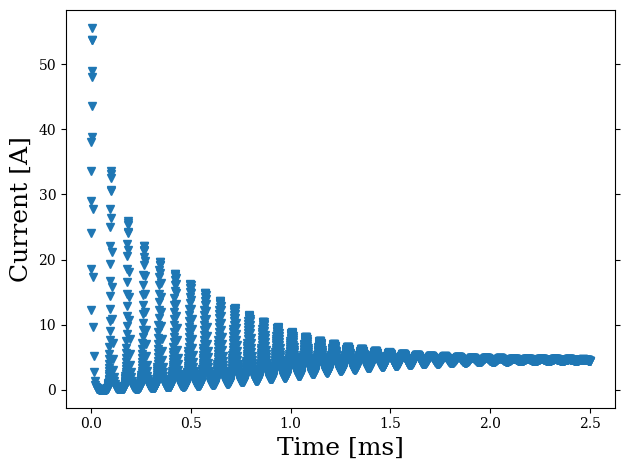

In [8]:
#####################################
#           Plot current            #
#####################################
plt.figure()
f, ax = plt.subplots()

ax.plot(time[1:] / 1e-3, Current[1:], "v")
# ax.axvline(x=time[-1000]/1e-3)
ax.set_xlabel(r"Time [ms]", fontsize=18)
ax.set_ylabel(r"Current [A]", fontsize=18)
# ax_V=ax.twinx()
# ax_V.plot(time/1e-3, Voltage,'r')
# ax_V.set_ylabel(r'Voltage [V]', fontsize=18)
ax.grid(True)
# ax.set_ylim(0, np.amax(Current[-2000:]))
# ax.set_yscale('log')
plt.tight_layout()
#plt.yscale("log")
plt.grid(False)


plt.savefig(ResultsFigs + "/Current.png", bbox_inches="tight", transparent=True)
print("Current plot saved in: ", ResultsFigs + "/Current.png")
print(np.mean(Current[:-1000]))

## PROFILES

Default Magnetic Field
Results_1D_test/PPS1350/Step/data_-1_-1/Data
Results_1D_test/PPS1350/Step/data_-1_-1/Figs
1:288.03 V , real: 300.03 V
2:289.49 V , real: 300.03 V


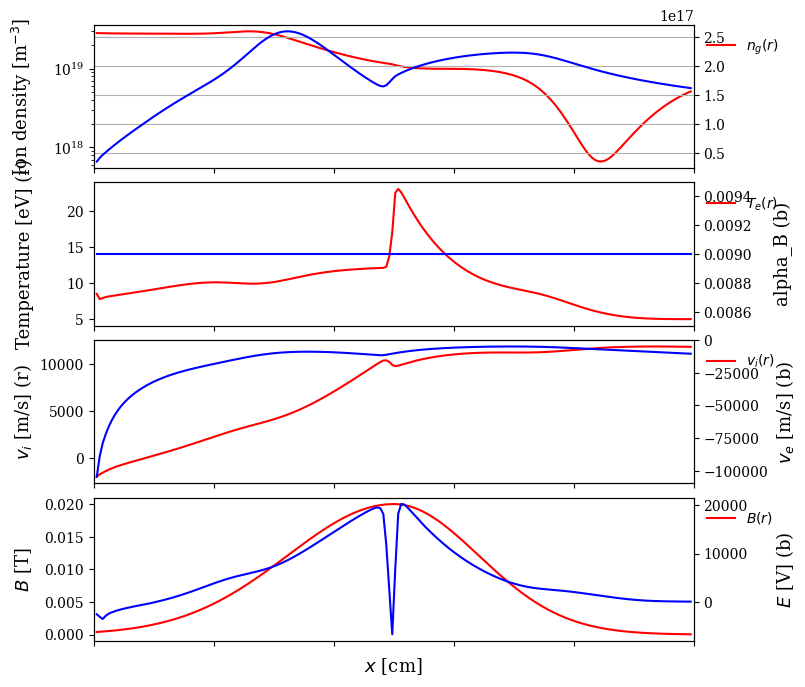

In [9]:
%load_ext autoreload
%autoreload 2
#####################################
#          Plot parameters          #
#####################################

colors = ["tab:red", "tab:green"]
fig = plt.figure(figsize=(10, 8))
gls = fig.add_gridspec(4, 1, hspace=0.1)
gls.update(left=0.15, right=0.75, wspace=0.05)
ax_n = fig.add_subplot(gls[0])
ax_T = fig.add_subplot(gls[1])
ax_v = fig.add_subplot(gls[2])
ax_B = fig.add_subplot(gls[3])
ax_n_t = ax_n.twinx()
ax_T_t = ax_T.twinx()
ax_v_t = ax_v.twinx()
ax_B_t = ax_B.twinx()

ind = 0

read_input_and_set_globals(Results + "/Configuration.cfg")
files = get_files(ResultsData)
print(ResultsData)

# i_save = -1
ng = np.zeros(NBPOINTS)
ni = np.zeros(NBPOINTS)
vi = np.zeros(NBPOINTS)
Te = np.zeros(NBPOINTS)
ve = np.zeros(NBPOINTS)
B_field = np.zeros(NBPOINTS)
E_field = np.zeros(NBPOINTS)

for i_save, file in enumerate(files[199:200]):
    with open(file, "rb") as f:
        [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
        ng += P[0, :]
        ni += P[1, :]
        vi += P[2, :]
        Te += P[3, :]
        ve += P[4, :]
        B_field += B

def compute_E(P,Current):
    def trapz(y,d):
        return np.sum(y[1:] + y[:-1])*d/2.0
    def gradient(y,d):
        dp_dz = np.empty_like(y)
        dp_dz[1:-1] = (y[2:] - y[:-2])/(2*d)
        dp_dz[0] = 2*dp_dz[1]-dp_dz[2]
        dp_dz[-1]= 2*dp_dz[-2]-dp_dz[-3]
        return dp_dz
    
    #############################################################
    #       We give a name to the vars to make it more readable
    #############################################################
    ng = P[0,:]
    ni = P[1,:]
    ui = P[2,:]
    Te = P[3,:]
    ve = P[4,:]
    Gamma_i = ni*ui
    wce     = phy_const.e*B/m              # electron cyclotron frequency
    
    #############################
    #       Compute the rates   #
    #############################
    if Gas_type == 'Xenon' :
        Eion = 12.1  # Ionization energy
        gamma_i = 3  # Excitation coefficient
        Kiz = (
            1.8e-13 * (((1.5 * Te) / Eion) ** 0.25) * np.exp(-4 * Eion / (3 * Te))
        )  # Ion - neutral  collision rate          TODO: Replace by better
        Kel = 2.5e-13                                                  # Electron - neutral  collision rate     TODO: Replace by good one
    elif Gas_type == 'Krypton' :
        Eion = 14
        gamma_i = 3  # Excitation coefficient
        Kiz = (
            1.6e-13 * (((1.5 * Te) / Eion) ** 0.25) * np.exp(-4 * Eion / (3 * Te))
        )  # Ion - neutral  collision rate          TODO: Replace by better
        Kel = 1.5e-13                                                  # Electron - neutral  collision rate     TODO: Replace by good one

    sigma = 2.*Te/Estar  # SEE yield
    sigma[sigma > 0.986] = 0.986

    nu_iw = (4./3.)*(1./(R2 - R1))*np.sqrt(phy_const.e*Te/M)       # Ion - wall collision rate
    #Limit the collisions to inside the thruster
    index_L0         = np.argmax(x_center > L0)
    nu_iw[index_L0:] = 0.
    
    nu_ew = nu_iw/(1 - sigma)                                      # Electron - wall collision rate

    nu_m   = ng*Kel + alpha_B()*wce + nu_ew                          # Electron momentum - transfer collision frequency
    
    mu_eff = (phy_const.e/(m*nu_m))*(1./(1 + (wce/nu_m)**2))       # Effective mobility
    dp_dz  = gradient(ni*Te, d = Delta_x)
    
    I0 = Current/(phy_const.e*A0)

    E = (I0 - Gamma_i) / (mu_eff * ni) - dp_dz / ni  # Discharge electric field
    return E
E_field = compute_E(P,J) 
 

ax_n.plot(x_center * 100, ng, color="r", label="$n_g(r)$ ")
ax_n_t.plot(x_center * 100, ni, color="b", label="$n_i(b)$ ")
ax_T.plot(x_center * 100, Te, color="r", label="$T_e(r)$ ")
ax_T_t.plot(x_center * 100, alpha_B(), color="b", label="$alpha_B(b)$ ")
ax_v.plot(x_center * 100, vi, color="r", label="$v_i(r)$ ")
ax_v_t.plot(x_center * 100, ve, color="b", label="$v_e(b)$ ")
ax_B.plot(x_center * 100, B_field, color="r", label="$B(r)$ ")
ax_B_t.plot(x_center * 100, E_field, color="b", label="$E(b)$ ")

ax_n.set_ylabel(r"Neutral gas density [m$^{-3}$]", fontsize=13)
ax_n.set_ylabel(r"Ion density [m$^{-3}$]", fontsize=13)
ax_T.set_ylabel(r"Temperature [eV] (r)", fontsize=13)
ax_T_t.set_ylabel(r"alpha_B (b)", fontsize=13)
ax_v.set_ylabel(r"$v_i$ [m/s] (r)", fontsize=13)
ax_v_t.set_ylabel(r"$v_e$ [m/s] (b)", fontsize=13)
ax_B.set_ylabel(r"$B$ [T]", fontsize=13)
ax_B_t.set_ylabel(r"$E$ [V] (b)", fontsize=13)
ax_B.set_xlabel(r"$x$ [cm]", fontsize=13)


ax_n.set_xlim(0, 5)
ax_T.set_xlim(0, 5)
ax_v.set_xlim(0, 5)
ax_B.set_xlim(0, 5)
ax_n.grid(False)
ax_T.grid(False)
ax_T_t.grid(False)
ax_v.grid(False)
ax_v_t.grid(False)
ax_B.grid(False)
ax_B_t.grid(False)
ax_n.set_xticklabels([])
ax_T.set_xticklabels([])
ax_v.set_xticklabels([])
ax_B.set_xticklabels([])

# ax0.set_ylim(1e16, 1e20)
# ax1.set_ylim(0, 15)
# ax2.set_ylim(-5e3, 15e3)
# ax2t.set_ylim(-1e5, 0)


ax_n.set_yscale("log")

ax_n.legend(bbox_to_anchor=(1.001, 1), loc="upper left", frameon=False)
ax_T.legend(bbox_to_anchor=(1.001, 1), loc="upper left", frameon=False)
ax_v.legend(bbox_to_anchor=(1.001, 1), loc="upper left", frameon=False)
ax_B.legend(bbox_to_anchor=(1.001, 1), loc="upper left", frameon=False)

fig.align_ylabels()
print(ResultsFigs)
plt.savefig(ResultsFigs+"Xenon_var")

import scipy as sc
verif_field=sc.integrate.simpson(E_field, x=x_center)
print(f"1:{verif_field:.2f} V", f", real: {V:.2f} V")
verif_field=sc.integrate.simpson(E_field, dx=x_center[0])
print(f"2:{verif_field:.2f} V", f", real: {V:.2f} V")
# print(x_center)

## PARAMETERS VARIATION

KeyboardInterrupt: 

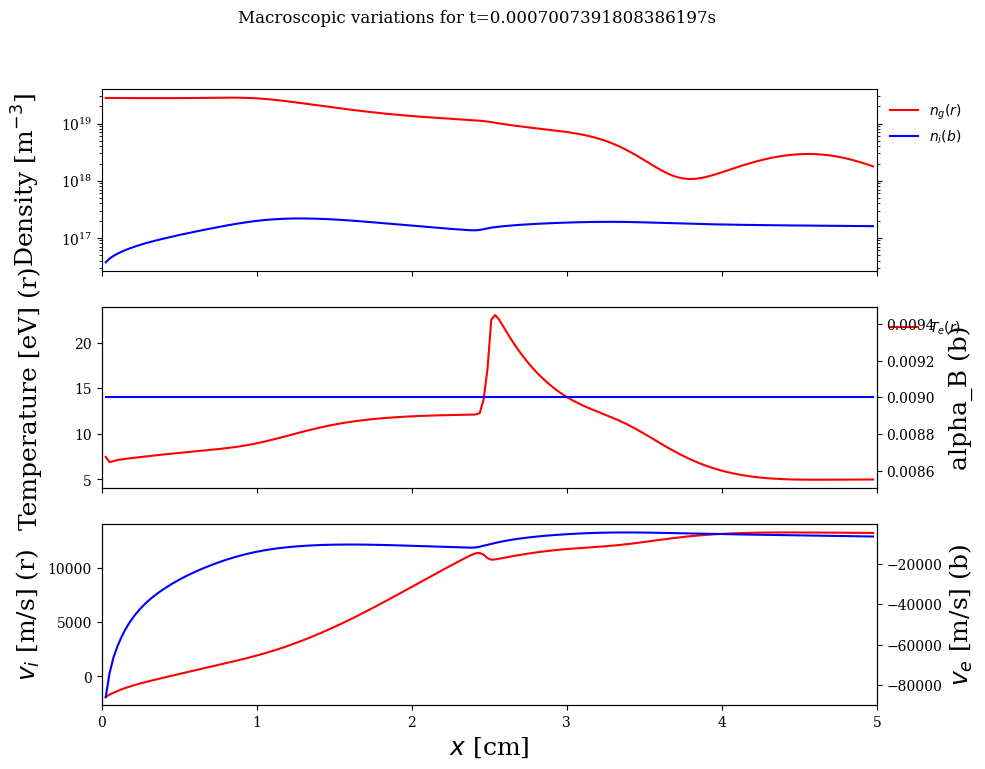

In [10]:
#####################################
#     Plot parameters variation     #
#####################################

ng_tot = []
ni_tot = []
vi_tot = []
Te_tot = []
ve_tot = []
Voltage_tot = []
for i_save, file in enumerate(files):
    with open(file, "rb") as f:
        [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
        ng_tot.append(P[0, :])
        ni_tot.append(P[1, :])
        vi_tot.append(P[2, :])
        Te_tot.append(P[3, :])
        ve_tot.append(P[4, :])
        Voltage_tot.append(V)


for i in range(len(ng_tot)):
    if int(time[i] * 10**6) % t_sampling == 0:
        clear_output(wait=False)
        fig = plt.figure(figsize=(10, 8))
        ax_n = plt.subplot(3, 1, 1)
        ax_T = plt.subplot(3, 1, 2)
        ax_v = plt.subplot(3, 1, 3)
        ax_T_t = ax_T.twinx()
        ax_v_t = ax_v.twinx()

        ax_n.plot(x_center * 100, ng_tot[i], "r", label="$n_g(r)$ ")
        ax_n.plot(x_center * 100, ni_tot[i], "b", label="$n_i(b)$ ")
        ax_T.plot(x_center * 100, Te_tot[i], "r", label="$T_e(r)$ ")
        ax_T_t.plot(x_center * 100, alpha_B(), color="b", label="$alpha_B(b)$ ")
        ax_v.plot(x_center * 100, vi_tot[i], "r", label="$v_i(r)$")
        ax_v_t.plot(x_center * 100, ve_tot[i], "b", label="$v_e(b)$")

        ax_n.set_ylabel(r"Density [m$^{-3}$]", fontsize=18)
        ax_T.set_ylabel(r"Temperature [eV] (r)", fontsize=18)
        ax_T_t.set_ylabel(r"alpha_B (b)", fontsize=18)
        ax_v.set_ylabel(r"$v_i$ [m/s] (r)", fontsize=18)
        ax_v_t.set_ylabel(r"$v_e$ [m/s] (b)", fontsize=18)
        ax_v.set_xlabel(r"$x$ [cm]", fontsize=18)
        ax_n.set_label("Parameters for t=" + str(time[i]) + "ms")

        ax_n.set_xlim(0, 5)
        ax_T.set_xlim(0, 5)
        ax_v.set_xlim(0, 5)
        ax_n.grid(False)
        ax_T.grid(False)
        ax_T_t.grid(False)
        ax_v.grid(False)
        ax_v_t.grid(False)
        ax_n.set_xticklabels([])
        ax_T.set_xticklabels([])

        ax_n.set_yscale("log")

        ax_n.legend(bbox_to_anchor=(1.001, 1), loc="upper left", frameon=False)
        ax_T.legend(bbox_to_anchor=(1.001, 1), loc="upper left", frameon=False)

        fig.align_ylabels()
        fig.suptitle("Macroscopic variations for t=" + str(time[i]) + "s")

        plt.savefig(
            ResultsFigs
            + "/MacroscopicVars_at "
            + str(i)
            + " iterations for t="
            + str(time[i])
            + "s.png",
            bbox_inches="tight",
        )
        plt.close()

In [ ]:
#####################################
#            Plot thrust            #
#####################################


Thrust_plot = []
for i in range(len(ng_tot)):
    if int(time[i] * 10**6) % t_sampling == 0:
        plt.figure()
        Thrust = []
        for j in range(len(ni_tot[i])):
            Thrust.append(M * A0 * ni_tot[i][j] * vi_tot[i][j] ** 2)
            Thrust_plot.append(Thrust[-1])
        print(Thrust[-1])
        plt.plot(x_center, Thrust)

    plt.show()
plt.figure()
plt.plot(time, Thrust_plot)
plt.show()

## Estimate energy equation terms

In [ ]:
def gradient(y, d):
    dp_dz = np.empty_like(y)
    dp_dz[1:-1] = (y[2:] - y[:-2]) / (2 * d)
    dp_dz[0] = 2 * dp_dz[1] - dp_dz[2]
    dp_dz[-1] = 2 * dp_dz[-2] - dp_dz[-3]

    return dp_dz


plt.figure()

t_vec = []
for i_save, file in enumerate(files[-2:-1]):
    with open(file, "rb") as f:
        [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
        t_vec.append(t)
        ng = P[0, :]
        ni = P[1, :]
        vi = P[2, :]
        Te = P[3, :]
        ve = P[4, :]
    Eion = 12.1  # Ionization energy
    gamma_i = 3  # Excitation coefficient
    # Estar   = 50    # Crossover energy

    Kiz = (
        1.8e-13 * (((1.5 * Te) / Eion) ** 0.25) * np.exp(-4 * Eion / (3 * Te))
    )  # Ion - neutral  collision rate          TODO: Replace by better
    sigma = 2.0 * Te / Estar  # SEE yield
    sigma[sigma > 0.986] = 0.986
    nu_iw = (
        (4.0 / 3.0) * (1.0 / (R2 - R1)) * np.sqrt(phy_const.e * Te / M)
    )  # Ion - wall collision rate
    # Limit the collisions to inside the thruster
    index_L0 = np.argmax(x_center > L0)
    nu_iw[index_L0:] = 0.0

    nu_ew = nu_iw / (1 - sigma)  # Electron - wall collision rate

    # TODO: Put decreasing wall collisions (Not needed for the moment)
    #    if decreasing_nu_iw:
    #        index_L1 = np.argmax(z > L1)
    #        index_L0 = np.argmax(z > L0)
    #        index_ind = index_L1 - index_L0 + 1
    #
    #        nu_iw[index_L0: index_L1] = nu_iw[index_L0] * np.arange(index_ind, 1, -1) / index_ind
    #        nu_iw[index_L1:] = 0.0

    ##################################################
    #       Compute the electron properties          #
    ##################################################
    phi_W = Te * np.log(np.sqrt(M / (2 * np.pi * m)) * (1 - sigma))  # Wall potential
    Ew = 2 * Te + (1 - sigma) * phi_W  # Energy lost at the wall

    Kel = 2.5e-13  # Electron - neutral collision rate
    wce = phy_const.e * B0 / m  # electron cyclotron frequency
    nu_m = (
        ng * Kel + alpha_B * wce + nu_ew
    )  # Electron momentum - transfer collision frequency
    mu_eff = (phy_const.e / (m * nu_m)) * (
        1.0 / (1 + (wce / nu_m) ** 2)
    )  # Effective mobility
    dpvdx = gradient(2.5 * phy_const.e * ni * Te * ve, d=Delta_x)

    S1 = -ng[:] * ni[:] * Kiz[:] + nu_iw[:] * ni[:]  # * M  # Gas Density
    P1 = gradient(ng * VG, Delta_x)

    # plt.plot(x_center, S1)
    # plt.plot(x_center, P1, "--")

    S2 = ng[:] * ni[:] * Kiz[:] - nu_iw[:] * ni[:]  # * M  # Ion Density
    P2 = gradient(ni * vi, Delta_x)

    # plt.plot(x_center, S2)
    # plt.plot(x_center, P2, "--")

    S3 = (
        ng * ni * Kiz * VG - (phy_const.e * ni * (ve) / (mu_eff * M)) - nu_iw * ni * ui
    )  # Ion momentum
    P3 = gradient(ni * vi**2 + ni * Te * phy_const.e / M, Delta_x)

    # plt.plot(x_center, S3)
    # plt.plot(x_center, P3, "--")
    div_p = gradient(
        phy_const.e * ni * Te, d=Delta_x
    )  # To be used with 5./2 and + div_p*ve below

    S4 = (
        -(ng * ni * Kiz * VG * Te)
        - nu_ew * ni * Ew * phy_const.e
        + ni / mu_eff * (ve) ** 2.0 * phy_const.e
        + div_p * ve
    )  # Energy
    P4 = gradient(2.5 * ni * phy_const.elementary_charge * Te * ve, Delta_x)

    # plt.plot(x_center, S4)
    plt.plot(x_center, P4 / 1e6, "-")

    plt.plot(x_center, (dpvdx) / 1e6, label="$\partial_t P_x$", ls="--")
    plt.plot(
        x_center, (-Source1 - Source2 + Source3 + Source4) / 1e6, label="Sum", ls="--"
    )


plt.legend()
dpdt = np.zeros(NBPOINTS)


Source1 = ng[:] * ni[:] * Kiz[:] * Eion * gamma_i * phy_const.e
Source2 = nu_ew[:] * ni[:] * Ew * phy_const.e
Source3 = ni[:] / mu_eff[:] * (ve) ** 2.0 * phy_const.e
Source4 = div_p * ve
S = (
    -ng[:] * ni[:] * Kiz[:] * Eion * gamma_i * phy_const.e
    - nu_ew[:] * ni[:] * Ew * phy_const.e
    + ni[:] / mu_eff[:] * (ve[:]) ** 2.0 * phy_const.e
    + div_p * ve
)  # + phy_const.e*ni*Te*div_u  #- gradI_term*ni*Te*grdI          # Energy

In [ ]:
plt.figure()
plt.plot(x_center, Source1 / 1e6, label=r"$n_g n K_{iz} E_{iz} \gamma_i$")
# plt.plot(x_center, -Source1/1e6, label = "Source1", ls = "--")
plt.plot(x_center, Source2 / 1e6, label=r"$\nu_{ew} n \Phi_w$")
# plt.plot(x_center, -Source2/1e6, label = "Source2", ls = "--")
plt.plot(x_center, Source3 / 1e6, label=r"$n v_{e}^2 / \mu_{eff}$", linewidth=2)
# plt.plot(x_center, -Source3/1e6, label = "Source3", ls = "--", linewidth = 2)
plt.plot(x_center, Source4 / 1e6, label=r"$v_{e,x} \nabla P_x $")
# plt.plot(x_center, -Source4/1e6, label = "Source4", ls = "--")
plt.plot(x_center, dpvdx / 1e6, label="$\partial_x P_x v_x$", ls="-")
# plt.plot(x_center, -dpvdx/1e6, label = "dpvdx", ls="--")
plt.plot(x_center, dpdt / 1e6, label="$\partial_t P_x$", ls="-")
# plt.plot(x_center, -dpdt/1e6, label = "dpdt", ls="--")

plt.figure()
plt.plot(x_center, (dpvdx) / 1e6, label="$\partial_t P_x$", ls="--")
plt.plot(x_center, (-Source1 - Source2 + Source3 + Source4) / 1e6, label="Sum", ls="--")

plt.ylabel("Energy eq. terms [$10^6$ W/m$^3$]")
plt.xlabel("$x$ [m]")
plt.grid(False)

plt.legend()
# plt.yscale('log')

In [ ]:
plt.figure()
# plt.plot(x_center, mu_eff, label = "mu_eff")
mu_eff = (phy_const.e / (m * nu_m)) * (1.0 / (1 + (wce / nu_m) ** 2))  # E
plt.plot(x_center, wce, label="wce")
plt.plot(x_center, nu_m, label="nu_m")
plt.legend()
plt.yscale("log")

### Compare profiles 

In [ ]:
def get_files(ResultsData):
    files = glob.glob(ResultsData + "/*.pkl")
    files.sort(key=os.path.getmtime)
    return files


root = "/home/petronio/Nextcloud/code/LPP1D/FLHET1D/Results/"
cases = ["data_cp_2_2/", "data_cp_2_2_noGradP/"]

root = "/home/petronio/Nextcloud/code/LPP1D/FLHET1D/test_multiple_alpha_B_SPT100/alpha_CP15/"

cases = ["data_cp_GradP/", "data_cp_noGradP/"]
cases = ["data_cp_GradP_psi16/", "data_cp_GradP_psi18/"]

cases_labels = ["with GradP", "without GradP"]

print(root + cases[0])

# test K_el constant
root = "/home/petronio/Nextcloud/code/LPP1D/FLHET1D/test_multiple_alpha_B_SPT100/vary_psi/data_cp_GradP_psi"
cases = ["0/", "1/", "2/", "3/", "4/", "5/", "6/"]
cases_labels = [
    "$K_{el} = 2.5\cdot 10^{-13}$ m$^3$/s",
    "$K_{el} = 5\cdot 10^{-13}$ m$^3$/s",
    "$K_{el} = 7.5\cdot 10^{-13}$ m$^3$/s",
    "$K_{el} = 10\cdot 10^{-13}$ m$^3$/s",
    "$K_{el} = 12.5\cdot 10^{-13}$ m$^3$/s",
    "$K_{el} = 15\cdot 10^{-13}$ m$^3$/s",
    "$K_{el} = 3.5\cdot 10^{-13}$ m$^3$/s",
]

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
for ind in [0, 6, 1, 2, 3, 4, 5]:
    Results = root + cases[ind]
    print(Results)
    time, Current, Voltage = np.loadtxt(Results + "cur_volt.dat")
    ax.plot(time / 1e-3, Current, label=cases_labels[ind])
ax.set_xlabel(r"Time [ms]", fontsize=18)
ax.set_ylabel(r"Current [A]", fontsize=18)
ax.set_ylim(0, 10)
ax.set_xlim(0, 2)

plt.tight_layout()
plt.grid(False)

plt.legend()
plt.savefig(
    "images_compare_Kel/Currents_changeKel.png", bbox_inches="tight", transparent=True
)

In [ ]:
fig = plt.figure(figsize=(10, 8))
gls = fig.add_gridspec(3, 1, hspace=0.1)
gls.update(left=0.15, right=0.5, wspace=0.05)
ax0 = fig.add_subplot(gls[0])
ax1 = fig.add_subplot(gls[1])

for ind in [0, 6, 1, 2, 3, 4, 5]:
    Results = root + cases[ind]
    ResultsData = Results + "Data"
    files = get_files(ResultsData)
    print(ResultsData, cases[ind], ind, len(files))
    read_input_and_set_globals(Results + "Configuration.cfg")

    # i_save = -1
    ng = np.zeros(NBPOINTS)
    ni = np.zeros(NBPOINTS)
    Te = np.zeros(NBPOINTS)

    for i_save, file in enumerate(files[-500:]):
        with open(file, "rb") as f:
            [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
            ng += P[0, :]
            ni += P[1, :]
            Te += P[3, :]
            if i_save == 0:
                print(t * 1e3)
    print(i_save + 1, len(files[-500:]))
    ng /= i_save + 1
    ni /= i_save + 1
    Te /= i_save + 1

    ax0.plot(x_center * 100, ng, label=cases_labels[ind], color=mcolors_list[ind])
    ax0.plot(x_center * 100, ni, color=mcolors_list[ind], ls="--")
    ax1.plot(x_center * 100, Te, color=mcolors_list[ind])
    # ax0.plot(x_center*100, ni, label = "$n_i$, " + cases_labels[ind], color = mcolors_list[ind], ls = '--')
    # ax1.plot(x_center*100, Te, label = "$T_e$, " + cases_labels[ind], color = mcolors_list[ind])

ax0.set_ylabel(r"Density [m$^{-3}$]", fontsize=18)
ax1.set_ylabel(r"Temperature [eV]", fontsize=18)
ax1.set_xlabel(r"$x$ [cm]", fontsize=18)

# ax0.set_title("average over last 100 time steps")

ax0.set_xlim(0, 5)
ax1.set_xlim(0, 5)
ax0.set_ylim(1e16, 1e20)
ax1.set_ylim(0, 20)
ax0.grid(False)
ax1.grid(False)
ax0.set_xticklabels([])

ax0.set_yscale("log")

ax0.legend(bbox_to_anchor=(1.001, 1), loc="upper left", frameon=False, fontsize=12)
ax1.legend(bbox_to_anchor=(1.001, 1), loc="upper left", frameon=False)

fig.align_ylabels()

plt.savefig(
    "images_compare_Kel/Profiles_changeKel.png", bbox_inches="tight", transparent=True
)

### Vi and Ve

In [ ]:
%load_ext autoreload
%autoreload 2

colors = [
    "tab:red",
    "tab:green",
    "tab:blue",
    "tab:orange",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
]
fig = plt.figure(figsize=(10, 10))
gls = fig.add_gridspec(4, 1, hspace=0.1)
gls.update(left=0.15, right=0.65, wspace=0.05)
ax0 = fig.add_subplot(gls[0])
ax1 = fig.add_subplot(gls[1])
ax2 = fig.add_subplot(gls[2])
ax2t = ax2.twinx()
ax3 = fig.add_subplot(gls[3])

for ind in [1, 3, 5]:
    Results = root + cases[ind]
    ResultsData = Results + "Data"
    read_input_and_set_globals(Results + "Configuration.cfg")
    files = get_files(ResultsData)
    print(ResultsData, cases[ind], ind, len(files))

    # i_save = -1
    ng = np.zeros(NBPOINTS)
    ni = np.zeros(NBPOINTS)
    vi = np.zeros(NBPOINTS)
    Te = np.zeros(NBPOINTS)
    ve = np.zeros(NBPOINTS)

    for i_save, file in enumerate(files[-500:]):
        with open(file, "rb") as f:
            [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
            ng += P[0, :]
            ni += P[1, :]
            vi += P[2, :]
            Te += P[3, :]
            ve += P[4, :]
    print(i_save + 1, len(files[-500:]))
    ng /= i_save + 1
    ni /= i_save + 1
    vi /= i_save + 1
    Te /= i_save + 1
    ve /= i_save + 1

    ax0.plot(x_center * 100, ng, color=colors[ind], label="$n_g$,~" + cases_labels[ind])
    ax0.plot(
        x_center * 100,
        ni,
        color=colors[ind],
        label="$n_i$,~" + cases_labels[ind],
        ls="--",
    )
    ax1.plot(x_center * 100, Te, color=colors[ind], label="$T_e$,~" + cases_labels[ind])
    ax2.plot(
        x_center * 100,
        vi,
        color=colors[ind],
        label="$v_i$,~" + cases_labels[ind],
        ls="--",
    )
    ax2t.plot(
        x_center * 100, ve, color=colors[ind], label="$v_e$,~" + cases_labels[ind]
    )
    ax3.plot(
        x_center * 100,
        phy_const.elementary_charge * ve * ni,
        color=colors[ind],
        label="e, " + cases_labels[ind],
        ls=":",
    )
    ax3.plot(
        x_center * 100,
        phy_const.elementary_charge * vi * ni,
        color=colors[ind],
        label="i, " + cases_labels[ind],
        ls="--",
    )
    ax3.plot(
        x_center * 100,
        phy_const.elementary_charge * (vi - ve) * ni,
        color=colors[ind],
        label="tot, " + cases_labels[ind],
        ls="-",
    )
    print(
        np.mean((vi - ve) * ni),
        np.mean(vi * ni),
        np.mean(ve * ni),
        np.mean(ni),
        np.mean(vi),
        np.mean(ve),
    )

ax0.set_ylabel(r"Density [m$^{-3}$]", fontsize=18)
ax1.set_ylabel(r"Temperature [eV]", fontsize=18)
ax2.set_ylabel(r"$v_i$ (dashed) [m/s]", fontsize=18)
ax2t.set_ylabel(r"$v_e$ [m/s]", fontsize=18)
ax3.set_xlabel(r"$x$ [cm]", fontsize=18)
ax3.set_ylabel(r"$J$ [A/m$^2$]", fontsize=18)


ax0.set_xlim(0, 5)
ax1.set_xlim(0, 5)
ax2.set_xlim(0, 5)
ax3.set_xlim(0, 5)
ax0.grid(False)
ax1.grid(False)
ax2.grid(False)
ax2t.grid(False)
ax3.grid(False)
ax0.set_xticklabels([])
ax1.set_xticklabels([])
ax2.set_xticklabels([])

# ax0.set_ylim(1e16, 1e20)
ax1.set_ylim(0, 15)
ax2.set_ylim(-5e3, 15e3)
ax2t.set_ylim(-1e5, 0)

# ax3.legend()

ax0.set_yscale("log")

ax0.legend(bbox_to_anchor=(1.001, 1), loc="upper left", frameon=False, fontsize=11)
ax1.legend(bbox_to_anchor=(1.001, 1), loc="upper left", frameon=False, fontsize=11)
ax3.legend(bbox_to_anchor=(1.001, 1), loc="upper left", frameon=False, fontsize=11)


fig.align_ylabels()

plt.savefig(
    "images_compare_gradP/Plasma_mean_profiles.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)

In [ ]:
%matplotlib notebook
from ipywidgets import *


def slider(index, ind):
    Results = root + cases[ind]
    ResultsData = Results + "Data"
    read_input_and_set_globals(Results + "Configuration.cfg")
    files = get_files(ResultsData)
    file = files[index]

    with open(file, "rb") as f:
        [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
        ng = P[0, :]
        ni = P[1, :]
        vi = P[2, :]
        Te = P[3, :]
        ve = P[4, :]
    return ng, ni, vi, Te, ve


colors = [
    "tab:red",
    "tab:green",
    "tab:blue",
    "tab:orange",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
]
fig = plt.figure(figsize=(10, 8))
gls = fig.add_gridspec(3, 1, hspace=0.1)
gls.update(left=0.15, right=0.75, wspace=0.05)
ax0 = fig.add_subplot(gls[0])
ax1 = fig.add_subplot(gls[1])
ax2 = fig.add_subplot(gls[2])
ax2t = ax2.twinx()

ng, ni, vi, Te, ve = slider(1000, 0)
ind = 0
(line1,) = ax0.plot(
    x_center * 100, ng, color=colors[ind], label="$n_g$ " + cases_labels[ind]
)
(line2,) = ax0.plot(
    x_center * 100, ni, color=colors[ind], label="$n_i$ " + cases_labels[ind], ls="--"
)
(line3,) = ax1.plot(
    x_center * 100, Te, color=colors[ind], label="$T_e$ " + cases_labels[ind]
)
(line4,) = ax2.plot(
    x_center * 100, vi, color=colors[ind], label="$v_i$ " + cases_labels[ind], ls="--"
)
(line5,) = ax2t.plot(
    x_center * 100, ve, color=colors[ind], label="$v_e$ " + cases_labels[ind]
)

ng, ni, vi, Te, ve = slider(1000, 1)
ind = 1
(line11,) = ax0.plot(
    x_center * 100, ng, color=colors[ind], label="$n_g$ " + cases_labels[ind]
)
(line22,) = ax0.plot(
    x_center * 100, ni, color=colors[ind], label="$n_i$ " + cases_labels[ind], ls="--"
)
(line33,) = ax1.plot(
    x_center * 100, Te, color=colors[ind], label="$T_e$ " + cases_labels[ind]
)
(line44,) = ax2.plot(
    x_center * 100, vi, color=colors[ind], label="$v_i$ " + cases_labels[ind], ls="--"
)
(line55,) = ax2t.plot(
    x_center * 100, ve, color=colors[ind], label="$v_e$ " + cases_labels[ind]
)


ax0.set_ylabel(r"Density [m$^{-3}$]", fontsize=18)
ax1.set_ylabel(r"Temperature [eV]", fontsize=18)
ax2.set_ylabel(r"$v_i$ (dashed) [m/s]", fontsize=18)
ax2t.set_ylabel(r"$v_e$ [m/s]", fontsize=18)
ax2.set_xlabel(r"$x$ [cm]", fontsize=18)


ax0.set_xlim(0, 5)
ax1.set_xlim(0, 5)
ax2.set_xlim(0, 5)
ax0.grid(False)
ax1.grid(False)
ax2.grid(False)
ax2t.grid(False)
ax0.set_xticklabels([])
ax1.set_xticklabels([])


ax0.set_yscale("log")

ax0.legend(bbox_to_anchor=(1.001, 1), loc="upper left", frameon=False)
ax1.legend(bbox_to_anchor=(1.001, 1), loc="upper left", frameon=False)

fig.align_ylabels()


def update(index):
    ng, ni, vi, Te, ve = slider(index, 0)
    line1.set_ydata(ng)
    line2.set_ydata(ni)
    line3.set_ydata(Te)
    line4.set_ydata(vi)
    line5.set_ydata(ve)

    ng, ni, vi, Te, ve = slider(index, 1)
    line11.set_ydata(ng)
    line22.set_ydata(ni)
    line33.set_ydata(Te)
    line44.set_ydata(vi)
    line55.set_ydata(ve)

    fig.canvas.draw_idle()


interact(update, index=(0, len(files) - 1, 1))

## Calculate collision frequencies

In [ ]:
Kiz = 2.5e-13

colors_n = ["red", "green", "blue", "orange", "purple"]
colorstab = ["tab:red", "tab:green", "tab:blue", "tab:orange", "tab:purple"]
color_list = [colors_n, colorstab]

fig = plt.figure(figsize=(10, 6))
gls = fig.add_gridspec(2, 1, hspace=0.1)
gls.update(left=0.15, right=0.65, wspace=0.05)
ax0 = fig.add_subplot(gls[0])
ax1 = fig.add_subplot(gls[1])

for ind in [0, 1]:
    colors = color_list[ind]
    print(colors)
    Results = root + cases[ind]
    ResultsData = Results + "Data"
    files = get_files(ResultsData)
    read_input_and_set_globals(Results + "Configuration.cfg")

    ng = np.zeros(NBPOINTS)
    ni = np.zeros(NBPOINTS)
    vi = np.zeros(NBPOINTS)
    Te = np.zeros(NBPOINTS)
    ve = np.zeros(NBPOINTS)

    for i_save, file in enumerate(files[-500:]):
        with open(file, "rb") as f:
            [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
            ng += P[0, :]
            ni += P[1, :]
            vi += P[2, :]
            Te += P[3, :]
            ve += P[4, :]
    print(i_save + 1, len(files[-500:]))
    ng /= i_save + 1
    ni /= i_save + 1
    vi /= i_save + 1
    Te /= i_save + 1
    ve /= i_save + 1

    nu_iz = ng * Kiz  # Ionization collision rate
    nu_an = alpha_B1 * phy_const.e * B / m  # Anomalous collision rate
    nu_an = np.where(x_center < L0, nu_an, alpha_B2 * phy_const.e * B / m)
    print(alpha_B1, alpha_B2)
    nu_iw = (
        (4.0 / 3.0) * (1.0 / (R2 - R1)) * np.sqrt(phy_const.e * Te / M)
    )  # Ion - wall collision rate
    sigma = 2.0 * Te / Estar  # SEE yield
    nu_ew = nu_iw / (1 - sigma)  # Electron - wall collision rate

    nu_tot = nu_iz + nu_an + nu_ew

    mobility = (phy_const.e / (m * nu_tot)) * (
        1.0 / (1 + (phy_const.e * B / (m * nu_tot)) ** 2)
    )  # Effective mobility
    mobility_std = (phy_const.e / (m * (nu_iz + nu_ew))) * (
        1.0 / (1 + (phy_const.e * B / (m * (nu_iz + nu_ew))) ** 2)
    )  # Effective mobility

    ax0.plot(
        x_center * 100,
        nu_iz,
        color=colors[0],
        label="$nu_{iz}$ " + cases_labels[ind],
        marker="v",
        markevery=(5 * ind, 10),
    )
    ax0.plot(
        x_center * 100,
        nu_an,
        color=colors[0 + 1],
        label="$nu_{an}$ " + cases_labels[ind],
        marker="d",
        markevery=(5 * ind, 10),
    )
    ax0.plot(
        x_center * 100,
        nu_iw,
        color=colors[0 + 2],
        label="$nu_{iw}$ " + cases_labels[ind],
        marker="X",
        markevery=(5 * ind, 10),
    )
    ax0.plot(
        x_center * 100,
        nu_ew,
        color=colors[0 + 3],
        label="$nu_{ew}$ " + cases_labels[ind],
        marker="o",
        markevery=(5 * ind, 10),
    )
    ax0.plot(
        x_center * 100,
        nu_tot,
        color=colors[0 + 4],
        label="$nu_{tot}$ " + cases_labels[ind],
        marker="s",
        markevery=(5 * ind, 10),
    )

    ax1.plot(
        x_center * 100,
        mobility,
        color=colors[0],
        label="mobility " + cases_labels[ind],
        marker="s",
        markevery=(5 * ind, 10),
    )
    ax1.plot(
        x_center * 100,
        mobility_std,
        color=colors[0 + 1],
        label="mobility std " + cases_labels[ind],
        marker="o",
        markevery=(5 * ind, 10),
    )

ax0.set_ylabel(r"Coll. rate [s$^{-1}$]", fontsize=18)
ax1.set_ylabel(r"$\mu$ [m$^2$/Vs]", fontsize=18)
ax1.set_xlabel(r"$x$ [cm]", fontsize=18)

for ax in [ax0, ax1]:
    ax.set_xlim(0, 5)
    ax.grid(False)
    ax.set_yscale("log")
ax0.set_xticklabels([])

ax0.set_ylim(1e4, 1e8)
ax1.set_ylim(1e-2, 1e4)


ax0.set_yscale("log")
ax1.set_yscale("log")

ax0.legend(bbox_to_anchor=(1.001, 1), loc="upper left", frameon=False)
ax1.legend(bbox_to_anchor=(1.001, 0.5), loc="upper left", frameon=False)

fig.align_ylabels()

# plt.savefig("images_compare_gradP/Plasma_coll_prof.png",dpi=300, bbox_inches='tight', transparent=True)

### Calculate potential and electric field

In [ ]:
Kiz = 2.5e-13

colors_n = ["red", "green", "blue", "orange", "purple"]
colorstab = ["tab:red", "tab:green", "tab:blue", "tab:orange", "tab:purple"]
markers = ["o", "s", "v", "d", "X"]
color_list = [colors_n, colorstab]

fig = plt.figure(figsize=(10, 6))
gls = fig.add_gridspec(2, 1, hspace=0.1)
gls.update(left=0.15, right=0.65, wspace=0.05)
ax0 = fig.add_subplot(gls[0])
ax1 = fig.add_subplot(gls[1])

for ind in [0, 1]:
    colors = color_list[ind]
    Results = root + cases[ind]
    ResultsData = Results + "Data"
    files = get_files(ResultsData)
    configFile = Results + "Configuration.cfg"
    read_input_and_set_globals(configFile)

    Ex = np.zeros(NBPOINTS)
    phi = np.zeros(NBPOINTS)

    for i_save, file in enumerate(files[-1:]):
        with open(file, "rb") as f:
            [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
            phi_id, Ex_id = compute_phi(P, J, B, configFile, V)
            phi += phi_id
            Ex += Ex_id
    Ex /= i_save + 1
    phi /= i_save + 1

    ax0.plot(
        x_center * 100,
        phi,
        color=colors[2 + ind],
        label="$\Phi$ " + cases_labels[ind],
        marker=markers[ind],
        markevery=(5 * ind, 10),
    )
    ax1.plot(
        x_center * 100,
        Ex / 1e3,
        color=colors[0 + ind],
        label="$E_x$ " + cases_labels[ind],
        marker=markers[2 + ind],
        markevery=(5 * ind, 10),
    )


ax0.set_ylabel(r"$\Phi$ [V]", fontsize=18)
ax1.set_ylabel(r"$E_x$ [kV/s]", fontsize=18)
ax1.set_xlabel(r"$x$ [cm]", fontsize=18)

for ax in [ax0, ax1]:
    ax.set_xlim(0, 5)
    ax.grid(False)
    ax.axhline(0, color="black", lw=1, ls="--")
ax0.set_xticklabels([])

ax0.set_ylim(0, 310)
ax1.set_ylim(-5, 30)


# ax0.set_yscale('log')
# ax1.set_yscale('log')

ax0.legend(bbox_to_anchor=(1.001, 1.0), loc="upper left", frameon=False)
ax1.legend(bbox_to_anchor=(1.001, 1.0), loc="upper left", frameon=False)

fig.align_ylabels()

plt.savefig(
    "images_compare_gradP/Ex_phi_profiles.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)

In [ ]:
## plot the anomalous transport terms comparison

## Collision rates

In [ ]:
import scipy as sc

xarray = np.logspace(-4, 3, 1000)

# cross_sec = np.loadtxt('elastic.txt')
coll1 = """  0.000000e+0	1.220000e-18
 1.000000e-4	1.220000e-18
 1.000000e-3	1.150000e-18
 5.000000e-3	9.700000e-19
 7.000000e-3	9.110000e-19
 1.000000e-2	8.390000e-19
 2.000000e-2	6.730000e-19
 3.000000e-2	5.610000e-19
 3.514000e-2	5.143070e-19
 7.152000e-2	3.119150e-19
 1.091700e-1	2.026200e-19
 1.481500e-1	1.360930e-19
 1.885000e-1	9.269560e-20
 2.302700e-1	6.291420e-20
 2.735000e-1	4.327490e-20
 3.182600e-1	2.922920e-20
 3.645800e-1	1.949420e-20
 4.125400e-1	1.279860e-20
 4.621800e-1	8.277060e-21
 5.135600e-1	5.318070e-21
 5.667500e-1	3.555770e-21
 6.218100e-1	2.748970e-21
 7.378000e-1	3.959240e-21
 7.988700e-1	5.586910e-21
 8.620900e-1	7.517850e-21
 9.275200e-1	9.751120e-21
 9.952600e-1	1.239780e-20
 1.065380e+0	1.549480e-20
 1.137960e+0	1.909240e-20
 1.213090e+0	2.323290e-20
 1.290870e+0	2.791280e-20
 1.371370e+0	3.311990e-20
 1.454710e+0	3.888300e-20
 1.540970e+0	4.507280e-20
 1.630270e+0	5.172510e-20
 1.722700e+0	5.886420e-20
 1.818380e+0	6.569230e-20
 1.917430e+0	7.316110e-20
 2.019950e+0	8.110350e-20
 2.126080e+0	8.874580e-20
 2.235940e+0	9.696730e-20
 2.349650e+0	1.058070e-19
 2.467370e+0	1.153050e-19
 2.589220e+0	1.248140e-19
 2.715350e+0	1.346910e-19
 2.845920e+0	1.452090e-19
 2.981070e+0	1.564070e-19
 3.120980e+0	1.687010e-19
 3.265800e+0	1.818740e-19
 3.415700e+0	1.959200e-19
 3.570880e+0	2.095590e-19
 3.731510e+0	2.222950e-19
 3.897790e+0	2.356760e-19
 4.069910e+0	2.489900e-19
 4.248070e+0	2.617720e-19
 4.432500e+0	2.750990e-19
 4.623410e+0	2.866980e-19
 4.821030e+0	2.973770e-19
 5.025600e+0	3.074230e-19
 5.237350e+0	3.108670e-19
 5.456540e+0	3.143260e-19
 5.683440e+0	3.179930e-19
 5.918310e+0	3.217260e-19
 6.413100e+0	3.171660e-19
 6.673610e+0	3.138530e-19
 6.943280e+0	3.106530e-19
 7.222430e+0	3.014210e-19
 7.511380e+0	2.909970e-19
 7.810490e+0	2.809790e-19
 8.120110e+0	2.685560e-19
 8.440610e+0	2.525120e-19
 8.772370e+0	2.374860e-19
 9.115790e+0	2.222910e-19
 9.471290e+0	2.060470e-19
 9.839270e+0	1.910430e-19
 1.022018e+1	1.789420e-19
 1.061449e+1	1.688810e-19
 1.102264e+1	1.594150e-19
 1.144515e+1	1.505070e-19
 1.188250e+1	1.421220e-19
 1.233521e+1	1.338160e-19
 1.280384e+1	1.258790e-19
 1.328894e+1	1.184330e-19
 1.379108e+1	1.114440e-19
 1.431087e+1	1.048850e-19
 1.484893e+1	9.872510e-20
 1.540590e+1	9.391070e-20
 1.598244e+1	8.969280e-20
 1.657924e+1	8.567280e-20
 1.719701e+1	8.184080e-20
 1.783649e+1	7.818740e-20
 1.849845e+1	7.454430e-20
 1.918366e+1	7.102670e-20
 1.989296e+1	6.768100e-20
 2.062719e+1	6.511300e-20
 2.138721e+1	6.274980e-20
 2.217395e+1	6.047590e-20
 2.298833e+1	5.828780e-20
 2.383133e+1	5.618200e-20
 2.470396e+1	5.415510e-20
 2.560725e+1	5.218750e-20
 2.654229e+1	5.028590e-20
 2.751018e+1	4.845600e-20
 2.851209e+1	4.669480e-20
 2.954921e+1	4.499960e-20
 3.062278e+1	4.348880e-20
 3.173407e+1	4.211650e-20
 3.288442e+1	4.078900e-20
 3.407519e+1	3.950460e-20
 3.530781e+1	3.826200e-20
 3.658374e+1	3.705950e-20
 3.790451e+1	3.589600e-20
 3.927170e+1	3.476990e-20
 4.068694e+1	3.369110e-20
 4.215191e+1	3.265810e-20
 4.366836e+1	3.165750e-20
 4.523810e+1	3.068840e-20
 4.686301e+1	2.974960e-20
 4.854502e+1	2.884020e-20
 5.028614e+1	2.796890e-20
 5.208844e+1	2.717330e-20
 5.395409e+1	2.640080e-20
 5.588529e+1	2.565080e-20
 5.788437e+1	2.492250e-20
 5.995369e+1	2.421530e-20
 6.209573e+1	2.361940e-20
 6.431306e+1	2.304040e-20
 6.660830e+1	2.247590e-20
 6.898420e+1	2.192550e-20
 7.144360e+1	2.143110e-20
 7.398942e+1	2.097750e-20
 7.662471e+1	2.053370e-20
 7.935261e+1	2.009950e-20
 8.217638e+1	1.974380e-20
 8.509938e+1	1.941510e-20
 8.812509e+1	1.909210e-20
 9.125714e+1	1.877900e-20
 9.449926e+1	1.847780e-20
 9.785531e+1	1.818160e-20
 1.013293e+2	1.795780e-20
 1.086478e+2	1.773660e-20
 1.164898e+2	1.751820e-20
 1.248925e+2	1.730260e-20
 1.338963e+2	1.699390e-20
 1.435440e+2	1.668960e-20
 1.538817e+2	1.619790e-20
 1.593245e+2	1.579560e-20
 1.649587e+2	1.540350e-20
 1.707908e+2	1.502120e-20
 1.768279e+2	1.464840e-20
 1.830772e+2	1.428500e-20
 1.895461e+2	1.393060e-20
 1.962423e+2	1.358510e-20
 2.031738e+2	1.325620e-20
 2.103489e+2	1.294470e-20
 2.177762e+2	1.264050e-20
 2.254644e+2	1.234350e-20
 2.334229e+2	1.205360e-20
 2.416610e+2	1.177050e-20
 2.501886e+2	1.149570e-20
 2.590160e+2	1.129850e-20
 2.681535e+2	1.110470e-20
 2.776121e+2	1.091430e-20
 2.874031e+2	1.072720e-20
 2.975383e+2	1.054330e-20
 3.080295e+2	1.040400e-20
 3.188895e+2	1.027930e-20
 3.301311e+2	1.015610e-20
 3.417678e+2	1.003450e-20
 3.538134e+2	9.914290e-21
 3.662823e+2	9.795540e-21
 3.791894e+2	9.678230e-21
 3.925501e+2	9.562340e-21
 4.063803e+2	9.433180e-21
 4.206965e+2	9.288630e-21
 4.355158e+2	9.146300e-21
 4.508559e+2	9.006160e-21
 4.667351e+2	8.868180e-21
 4.831724e+2	8.732330e-21
 5.001872e+2	8.597580e-21
 5.178000e+2	8.377120e-21
 5.360318e+2	8.162320e-21
 5.549043e+2	7.953040e-21
 5.744399e+2	7.749140e-21
 5.946621e+2	7.550480e-21
 6.155950e+2	7.396620e-21
 6.372635e+2	7.259500e-21
 6.596934e+2	7.124930e-21
 6.829117e+2	6.992860e-21
 7.069458e+2	6.853740e-21
 7.318245e+2	6.694130e-21
 7.575776e+2	6.538250e-21
 7.842356e+2	6.386000e-21
 8.118305e+2	6.251370e-21
 8.403951e+2	6.138300e-21
 8.699636e+2	6.027280e-21
 9.005711e+2	5.918270e-21
 9.322543e+2	5.811240e-21
 9.650509e+2	5.706150e-21"""

coll2 = """ 8.315000e+0	0.000000e+0
 8.315100e+0	3.314210e-25
 8.350140e+0	1.163510e-22
 8.386520e+0	2.065670e-22
 8.424170e+0	2.545050e-22
 8.463150e+0	2.673690e-22
 8.503500e+0	2.621010e-22
 8.545270e+0	2.871610e-22
 8.588500e+0	3.331230e-22
 8.633260e+0	3.819170e-22
 8.679580e+0	4.343160e-22
 8.727540e+0	4.899430e-22
 8.777180e+0	5.529600e-22
 8.828560e+0	6.331240e-22
 8.881750e+0	7.462020e-22
 8.936810e+0	8.930680e-22
 8.993800e+0	1.043890e-21
 9.052800e+0	1.150560e-21
 9.113870e+0	1.148900e-21
 9.177090e+0	1.098330e-21
 9.242520e+0	1.062990e-21
 9.310260e+0	1.086420e-21
 9.380380e+0	1.210760e-21
 9.452960e+0	1.476730e-21
 9.528090e+0	2.251040e-21
 9.605870e+0	2.086020e-21
 9.686370e+0	1.519960e-21
 9.769710e+0	1.451820e-21
 9.855970e+0	1.520380e-21
 9.945270e+0	1.596210e-21
 1.003770e+1	1.666390e-21
 1.013338e+1	1.733370e-21
 1.023243e+1	1.802700e-21
 1.033495e+1	1.874470e-21
 1.044108e+1	1.948760e-21
 1.055094e+1	2.025660e-21
 1.066465e+1	2.102020e-21
 1.078237e+1	2.178540e-21
 1.090422e+1	2.257740e-21
 1.103035e+1	2.337000e-21
 1.116092e+1	2.410110e-21
 1.129607e+1	2.485800e-21
 1.143597e+1	2.564150e-21
 1.158079e+1	2.645240e-21
 1.173070e+1	2.729190e-21
 1.188588e+1	2.816090e-21
 1.204651e+1	2.902330e-21
 1.221279e+1	2.982140e-21
 1.238491e+1	3.064760e-21
 1.256307e+1	3.150280e-21
 1.274750e+1	3.238800e-21
 1.293841e+1	3.330440e-21
 1.313603e+1	3.429380e-21
 1.334060e+1	3.533700e-21
 1.355235e+1	3.641700e-21
 1.377154e+1	3.753490e-21
 1.399844e+1	3.869200e-21
 1.423331e+1	3.958660e-21
 1.447643e+1	4.051040e-21
 1.472810e+1	4.146680e-21
 1.498861e+1	4.245670e-21
 1.525828e+1	4.337820e-21
 1.553743e+1	4.432720e-21
 1.582638e+1	4.530970e-21
 1.612549e+1	4.623250e-21
 1.643511e+1	4.705300e-21
 1.675561e+1	4.790240e-21
 1.708737e+1	4.878150e-21
 1.743079e+1	4.969160e-21
 1.778629e+1	5.063370e-21
 1.815427e+1	5.150850e-21
 1.853518e+1	5.227040e-21
 1.892949e+1	5.305900e-21
 1.933764e+1	5.387530e-21
 1.976015e+1	5.472030e-21
 2.019750e+1	5.548640e-21
 2.065021e+1	5.614280e-21
 2.111884e+1	5.682230e-21
 2.160394e+1	5.752570e-21
 2.210608e+1	5.821140e-21
 2.262587e+1	5.875720e-21
 2.316393e+1	5.932210e-21
 2.372090e+1	5.990690e-21
 2.429744e+1	6.040820e-21
 2.489424e+1	6.082600e-21
 2.551201e+1	6.125840e-21
 2.615149e+1	6.166060e-21
 2.681345e+1	6.192540e-21
 2.749866e+1	6.219950e-21
 2.820796e+1	6.245200e-21
 2.894218e+1	6.263550e-21
 2.970221e+1	6.282560e-21
 3.048895e+1	6.294890e-21
 3.130333e+1	6.303030e-21
 3.214633e+1	6.311460e-21
 3.301896e+1	6.320190e-21
 3.392225e+1	6.329220e-21
 3.485729e+1	6.338570e-21
 3.582518e+1	6.331750e-21
 3.682709e+1	6.321730e-21
 3.786421e+1	6.311360e-21
 3.893778e+1	6.300620e-21
 4.004907e+1	6.288090e-21
 4.119942e+1	6.243220e-21
 4.239019e+1	6.196780e-21
 4.362281e+1	6.148710e-21
 4.489874e+1	6.098950e-21
 4.621951e+1	6.047440e-21
 4.758670e+1	5.994120e-21
 4.900194e+1	5.938920e-21
 5.046691e+1	5.891130e-21
 5.198336e+1	5.862320e-21
 5.355310e+1	5.832490e-21
 5.517801e+1	5.801620e-21
 5.686002e+1	5.769660e-21
 5.860114e+1	5.736580e-21
 6.040344e+1	5.696690e-21
 6.226909e+1	5.635120e-21
 6.420029e+1	5.571390e-21
 6.619937e+1	5.505420e-21
 6.826869e+1	5.437130e-21
 7.041073e+1	5.368090e-21
 7.262805e+1	5.303790e-21
 7.492330e+1	5.237220e-21
 7.729920e+1	5.168320e-21
 7.975860e+1	5.097000e-21
 8.230442e+1	5.023170e-21
 8.493971e+1	4.946750e-21
 8.766761e+1	4.867640e-21
 9.049138e+1	4.788210e-21
 9.341437e+1	4.718050e-21
 9.644009e+1	4.645440e-21
 9.957214e+1	4.570270e-21
 1.028143e+2	4.499490e-21
 1.061703e+2	4.427340e-21
 1.096443e+2	4.352650e-21
 1.132404e+2	4.275330e-21
 1.169628e+2	4.195300e-21
 1.208161e+2	4.114090e-21
 1.248048e+2	4.036310e-21
 1.289336e+2	3.955790e-21
 1.332075e+2	3.872450e-21
 1.376317e+2	3.786180e-21
 1.422113e+2	3.713460e-21
 1.469518e+2	3.656580e-21
 1.518590e+2	3.597690e-21
 1.569386e+2	3.536740e-21
 1.621967e+2	3.473640e-21
 1.676395e+2	3.408330e-21
 1.732737e+2	3.340720e-21
 1.791058e+2	3.270730e-21
 1.851429e+2	3.211140e-21
 1.913922e+2	3.151770e-21
 1.978611e+2	3.090320e-21
 2.045573e+2	3.026710e-21
 2.114888e+2	2.960860e-21
 2.186639e+2	2.892690e-21
 2.260912e+2	2.822130e-21
 2.337794e+2	2.749100e-21
 2.417379e+2	2.679570e-21
 2.499760e+2	2.630140e-21
 2.585036e+2	2.578980e-21
 2.673310e+2	2.526010e-21
 2.764685e+2	2.471190e-21
 2.859271e+2	2.414440e-21
 2.957181e+2	2.355690e-21
 3.058533e+2	2.294880e-21
 3.163445e+2	2.231930e-21
 3.272045e+2	2.182980e-21
 3.384461e+2	2.140830e-21
 3.500828e+2	2.097190e-21
 3.621284e+2	2.052550e-21
 3.745973e+2	2.008910e-21
 3.875044e+2	1.963730e-21
 4.008651e+2	1.916710e-21
 4.146953e+2	1.864160e-21
 4.290115e+2	1.809760e-21
 4.438308e+2	1.753440e-21
 4.591709e+2	1.702490e-21
 4.750501e+2	1.654850e-21
 4.914874e+2	1.605540e-21
 5.085022e+2	1.563850e-21
 5.261150e+2	1.530380e-21
 5.443468e+2	1.495740e-21
 5.632193e+2	1.459880e-21
 5.827549e+2	1.422770e-21
 6.029771e+2	1.385830e-21
 6.239100e+2	1.356530e-21
 6.455785e+2	1.326190e-21
 6.680085e+2	1.294790e-21
 6.912266e+2	1.262280e-21
 7.152608e+2	1.227110e-21
 7.401395e+2	1.189790e-21
 7.658926e+2	1.151160e-21
 7.925506e+2	1.111170e-21
 8.201455e+2	1.081870e-21
 8.487101e+2	1.056160e-21
 8.782786e+2	1.029550e-21"""

coll3 = """  9.447000e+0	0.000000e+0
 9.447100e+0	1.166570e-24
 9.482140e+0	8.192700e-23
 9.518520e+0	1.265190e-22
 9.556170e+0	1.578770e-22
 9.595150e+0	1.570970e-22
 9.635500e+0	1.520300e-22
 9.677270e+0	1.641800e-22
 9.720500e+0	2.145450e-22
 9.765260e+0	3.005120e-22
 9.811580e+0	4.001150e-22
 9.859540e+0	5.247970e-22
 9.909180e+0	6.533100e-22
 9.960560e+0	7.838250e-22
 1.001375e+1	9.153510e-22
 1.006881e+1	1.040890e-21
 1.012580e+1	1.170830e-21
 1.018480e+1	1.305350e-21
 1.024587e+1	1.438620e-21
 1.030909e+1	1.574540e-21
 1.037452e+1	1.715230e-21
 1.044226e+1	1.848180e-21
 1.051238e+1	1.977900e-21
 1.058496e+1	2.112180e-21
 1.066009e+1	2.234650e-21
 1.073787e+1	2.357140e-21
 1.081837e+1	2.483940e-21
 1.090171e+1	2.615190e-21
 1.098797e+1	2.751060e-21
 1.107727e+1	2.858860e-21
 1.116970e+1	2.965160e-21
 1.126538e+1	3.075190e-21
 1.136443e+1	3.189090e-21
 1.146695e+1	3.306990e-21
 1.157308e+1	3.429040e-21
 1.168294e+1	3.555380e-21
 1.179665e+1	3.686150e-21
 1.191437e+1	3.821520e-21
 1.203622e+1	3.944990e-21
 1.216235e+1	4.032020e-21
 1.229292e+1	4.122110e-21
 1.242807e+1	4.215370e-21
 1.256797e+1	4.311900e-21
 1.271279e+1	4.411830e-21
 1.286270e+1	4.515270e-21
 1.301788e+1	4.617690e-21
 1.317851e+1	4.686760e-21
 1.334479e+1	4.758260e-21
 1.351691e+1	4.832270e-21
 1.369507e+1	4.908880e-21
 1.387950e+1	4.988190e-21
 1.407041e+1	5.058310e-21
 1.426803e+1	5.109690e-21
 1.447260e+1	5.162870e-21
 1.468435e+1	5.217930e-21
 1.490354e+1	5.274920e-21
 1.513044e+1	5.318260e-21
 1.536531e+1	5.351140e-21
 1.560843e+1	5.385180e-21
 1.586010e+1	5.420410e-21
 1.612061e+1	5.447840e-21
 1.639028e+1	5.465370e-21
 1.666943e+1	5.483510e-21
 1.695838e+1	5.502290e-21
 1.725749e+1	5.521740e-21
 1.756711e+1	5.541860e-21
 1.788761e+1	5.562690e-21
 1.821937e+1	5.567810e-21
 1.856279e+1	5.564370e-21
 1.891829e+1	5.560820e-21
 1.928627e+1	5.557140e-21
 1.966718e+1	5.553330e-21
 2.006149e+1	5.547540e-21
 2.046964e+1	5.531210e-21
 2.089215e+1	5.514310e-21
 2.132950e+1	5.496820e-21
 2.178221e+1	5.478710e-21
 2.225084e+1	5.458710e-21
 2.273594e+1	5.436880e-21
 2.323808e+1	5.414290e-21
 2.375787e+1	5.390900e-21
 2.429593e+1	5.362240e-21
 2.485290e+1	5.328830e-21
 2.542944e+1	5.294230e-21
 2.602624e+1	5.258560e-21
 2.664401e+1	5.224580e-21
 2.728349e+1	5.189410e-21
 2.794545e+1	5.153000e-21
 2.863066e+1	5.112160e-21
 2.933996e+1	5.069600e-21
 3.007418e+1	5.025850e-21
 3.083421e+1	4.983280e-21
 3.162095e+1	4.939230e-21
 3.243533e+1	4.893620e-21
 3.327833e+1	4.846410e-21
 3.415096e+1	4.797550e-21
 3.505425e+1	4.747290e-21
 3.598929e+1	4.700540e-21
 3.695718e+1	4.652140e-21
 3.795909e+1	4.602050e-21
 3.899621e+1	4.550190e-21
 4.006978e+1	4.497070e-21
 4.118107e+1	4.450390e-21
 4.233142e+1	4.402080e-21
 4.352219e+1	4.352070e-21
 4.475481e+1	4.300300e-21
 4.603074e+1	4.246710e-21
 4.735151e+1	4.191240e-21
 4.871870e+1	4.133810e-21
 5.013394e+1	4.075450e-21
 5.159891e+1	4.025640e-21
 5.311536e+1	3.974080e-21
 5.468510e+1	3.920710e-21
 5.631001e+1	3.865460e-21
 5.799202e+1	3.808270e-21
 5.973314e+1	3.749070e-21
 6.153544e+1	3.697010e-21
 6.340109e+1	3.644770e-21
 6.533229e+1	3.590700e-21
 6.733137e+1	3.534720e-21
 6.940069e+1	3.476780e-21
 7.154273e+1	3.424520e-21
 7.376005e+1	3.373520e-21
 7.605530e+1	3.320730e-21
 7.843120e+1	3.266080e-21
 8.089060e+1	3.211300e-21
 8.343642e+1	3.157840e-21
 8.607171e+1	3.102490e-21
 8.879961e+1	3.045210e-21
 9.162338e+1	2.990780e-21
 9.454637e+1	2.938170e-21
 9.757209e+1	2.883700e-21
 1.007041e+2	2.829790e-21
 1.039463e+2	2.782780e-21
 1.073023e+2	2.734120e-21
 1.107763e+2	2.683740e-21
 1.143724e+2	2.631600e-21
 1.180948e+2	2.577630e-21
 1.219481e+2	2.527600e-21
 1.259368e+2	2.481730e-21
 1.300656e+2	2.434250e-21
 1.343395e+2	2.385100e-21
 1.387637e+2	2.334220e-21
 1.433433e+2	2.289910e-21
 1.480838e+2	2.247250e-21
 1.529910e+2	2.203080e-21
 1.580706e+2	2.157360e-21
 1.633287e+2	2.115040e-21
 1.687715e+2	2.074210e-21
 1.744057e+2	2.031960e-21
 1.802378e+2	1.988340e-21
 1.862749e+2	1.946080e-21
 1.925242e+2	1.902330e-21
 1.989931e+2	1.857050e-21
 2.056893e+2	1.820130e-21
 2.126208e+2	1.783740e-21
 2.197959e+2	1.746070e-21
 2.272232e+2	1.707080e-21
 2.349114e+2	1.666710e-21
 2.428699e+2	1.628520e-21
 2.511080e+2	1.595570e-21
 2.596356e+2	1.561460e-21
 2.684630e+2	1.526150e-21
 2.776005e+2	1.489600e-21
 2.870591e+2	1.455290e-21
 2.968501e+2	1.421020e-21
 3.069853e+2	1.385550e-21
 3.174765e+2	1.348830e-21
 3.283365e+2	1.319160e-21
 3.395781e+2	1.291050e-21
 3.512148e+2	1.261960e-21
 3.632604e+2	1.231850e-21
 3.757293e+2	1.200680e-21
 3.886364e+2	1.168410e-21
 4.019971e+2	1.136800e-21
 4.158273e+2	1.114680e-21
 4.301435e+2	1.091770e-21
 4.449628e+2	1.068060e-21
 4.603029e+2	1.041450e-21
 4.761821e+2	1.012870e-21
 4.926194e+2	9.832850e-22
 5.096342e+2	9.585350e-22
 5.272470e+2	9.375760e-22
 5.454788e+2	9.158800e-22
 5.643513e+2	8.934220e-22
 5.838869e+2	8.701750e-22
 6.041091e+2	8.470960e-22
 6.250420e+2	8.272100e-22
 6.467105e+2	8.066250e-22
 6.691404e+2	7.853170e-22
 6.923587e+2	7.632590e-22
 7.163928e+2	7.441970e-22
 7.412715e+2	7.262840e-22
 7.670246e+2	7.077420e-22
 7.936826e+2	6.885490e-22
 8.212775e+2	6.712330e-22
 8.498421e+2	6.540950e-22
 8.794106e+2	6.363540e-22
 9.100181e+2	6.190910e-22
 9.417013e+2	6.035660e-22
 9.744979e+2	5.874960e-22"""

coll4 = """  9.917000e+0	0.000000e+0
 9.917100e+0	6.024080e-29
 9.952140e+0	2.116990e-26
 9.988520e+0	4.308380e-26
 1.002617e+1	5.095320e-23
 1.006515e+1	1.267570e-22
 1.010550e+1	2.052250e-22
 1.014727e+1	2.864510e-22
 1.019050e+1	3.705310e-22
 1.023526e+1	5.284410e-22
 1.028158e+1	7.116620e-22
 1.032954e+1	9.013210e-22
 1.037918e+1	1.097650e-21
 1.043056e+1	1.290020e-21
 1.048375e+1	1.481500e-21
 1.053881e+1	1.679720e-21
 1.059580e+1	1.884890e-21
 1.065480e+1	2.071250e-21
 1.071587e+1	2.262100e-21
 1.077909e+1	2.459650e-21
 1.084452e+1	2.664140e-21
 1.091226e+1	2.875820e-21
 1.098238e+1	3.094940e-21
 1.105496e+1	3.314890e-21
 1.113009e+1	3.540280e-21
 1.120787e+1	3.773600e-21
 1.128837e+1	4.015120e-21
 1.137171e+1	4.265130e-21
 1.145797e+1	4.523920e-21
 1.154727e+1	4.791800e-21
 1.163970e+1	5.069100e-21
 1.173538e+1	5.356150e-21
 1.183443e+1	5.653280e-21
 1.193695e+1	5.960850e-21
 1.204308e+1	6.234000e-21
 1.215294e+1	6.448230e-21
 1.226665e+1	6.669980e-21
 1.238437e+1	6.899520e-21
 1.250622e+1	7.137130e-21
 1.263235e+1	7.383090e-21
 1.276292e+1	7.637690e-21
 1.289807e+1	7.901240e-21
 1.303798e+1	8.148990e-21
 1.318280e+1	8.335810e-21
 1.333270e+1	8.529190e-21
 1.348788e+1	8.729370e-21
 1.364851e+1	8.936580e-21
 1.381479e+1	9.151080e-21
 1.398691e+1	9.373110e-21
 1.416507e+1	9.540220e-21
 1.434950e+1	9.708050e-21
 1.454041e+1	9.881780e-21
 1.473803e+1	1.006160e-20
 1.494260e+1	1.024780e-20
 1.515435e+1	1.037720e-20
 1.537354e+1	1.048680e-20
 1.560044e+1	1.060020e-20
 1.583531e+1	1.071770e-20
 1.607843e+1	1.082350e-20
 1.633010e+1	1.089900e-20
 1.659061e+1	1.097720e-20
 1.686028e+1	1.105810e-20
 1.713943e+1	1.114180e-20
 1.742838e+1	1.122850e-20
 1.772749e+1	1.131820e-20
 1.803711e+1	1.140560e-20
 1.835761e+1	1.145360e-20
 1.868937e+1	1.150340e-20
 1.903279e+1	1.155490e-20
 1.938829e+1	1.160820e-20
 1.975627e+1	1.166340e-20
 2.013718e+1	1.170000e-20
 2.053149e+1	1.170000e-20
 2.093964e+1	1.170000e-20
 2.136215e+1	1.170000e-20
 2.179950e+1	1.170000e-20
 2.225221e+1	1.168740e-20
 2.272084e+1	1.166400e-20
 2.320594e+1	1.163970e-20
 2.370808e+1	1.161460e-20
 2.422787e+1	1.158860e-20
 2.476593e+1	1.156170e-20
 2.532290e+1	1.153390e-20
 2.589944e+1	1.150500e-20
 2.649624e+1	1.145040e-20
 2.711401e+1	1.138860e-20
 2.775349e+1	1.132470e-20
 2.841545e+1	1.125850e-20
 2.910066e+1	1.118990e-20
 2.980996e+1	1.111900e-20
 3.054419e+1	1.105650e-20
 3.130421e+1	1.099570e-20
 3.209095e+1	1.093270e-20
 3.290533e+1	1.086760e-20
 3.374833e+1	1.080010e-20
 3.462096e+1	1.073030e-20
 3.552425e+1	1.064760e-20
 3.645929e+1	1.055410e-20
 3.742718e+1	1.045730e-20
 3.842909e+1	1.035710e-20
 3.946621e+1	1.025340e-20
 4.053978e+1	1.015140e-20
 4.165107e+1	1.005140e-20
 4.280142e+1	9.947870e-21
 4.399219e+1	9.840700e-21
 4.522481e+1	9.729770e-21
 4.650074e+1	9.614930e-21
 4.782151e+1	9.496060e-21
 4.918870e+1	9.373020e-21
 5.060394e+1	9.256520e-21
 5.206891e+1	9.151040e-21
 5.358536e+1	9.041850e-21
 5.515510e+1	8.928830e-21
 5.678001e+1	8.811840e-21
 5.846202e+1	8.690730e-21
 6.020314e+1	8.568220e-21
 6.200544e+1	8.463680e-21
 6.387109e+1	8.355480e-21
 6.580229e+1	8.243470e-21
 6.780137e+1	8.127520e-21
 6.987069e+1	8.007500e-21
 7.201273e+1	7.889300e-21
 7.423006e+1	7.767350e-21
 7.652530e+1	7.641110e-21
 7.890120e+1	7.510430e-21
 8.136060e+1	7.390130e-21
 8.390642e+1	7.278120e-21
 8.654171e+1	7.162160e-21
 8.926961e+1	7.042140e-21
 9.209338e+1	6.926260e-21
 9.501638e+1	6.809340e-21
 9.804209e+1	6.688320e-21
 1.011741e+2	6.571840e-21
 1.044163e+2	6.466470e-21
 1.077723e+2	6.357400e-21
 1.112463e+2	6.244500e-21
 1.148424e+2	6.127620e-21
 1.185648e+2	6.006640e-21
 1.224181e+2	5.897130e-21
 1.264068e+2	5.793420e-21
 1.305356e+2	5.686070e-21
 1.348095e+2	5.574950e-21
 1.392337e+2	5.459920e-21
 1.438133e+2	5.358010e-21
 1.485538e+2	5.256090e-21
 1.534610e+2	5.150590e-21
 1.585406e+2	5.041380e-21
 1.637987e+2	4.943520e-21
 1.692415e+2	4.848270e-21
 1.748757e+2	4.749680e-21
 1.807078e+2	4.649030e-21
 1.867449e+2	4.555450e-21
 1.929942e+2	4.458590e-21
 1.994631e+2	4.358320e-21
 2.061593e+2	4.274550e-21
 2.130908e+2	4.189640e-21
 2.202659e+2	4.101740e-21
 2.276932e+2	4.010760e-21
 2.353814e+2	3.916580e-21
 2.433399e+2	3.828270e-21
 2.515780e+2	3.750010e-21
 2.601056e+2	3.669000e-21
 2.689330e+2	3.585140e-21
 2.780705e+2	3.498330e-21
 2.875291e+2	3.423530e-21
 2.973202e+2	3.350100e-21
 3.074553e+2	3.274090e-21
 3.179465e+2	3.195400e-21
 3.288065e+2	3.122760e-21
 3.400481e+2	3.049690e-21
 3.516848e+2	2.974050e-21
 3.637304e+2	2.900420e-21
 3.761993e+2	2.834950e-21
 3.891064e+2	2.767190e-21
 4.024671e+2	2.699140e-21
 4.162973e+2	2.638290e-21
 4.306135e+2	2.575300e-21
 4.454328e+2	2.510100e-21
 4.607729e+2	2.449060e-21
 4.766521e+2	2.388720e-21
 4.930894e+2	2.326260e-21
 5.101042e+2	2.271710e-21
 5.277170e+2	2.222390e-21
 5.459488e+2	2.171340e-21
 5.648213e+2	2.118500e-21
 5.843569e+2	2.063800e-21
 6.045791e+2	2.009930e-21
 6.255120e+2	1.963870e-21
 6.471805e+2	1.916200e-21
 6.696105e+2	1.866860e-21
 6.928287e+2	1.815780e-21
 7.168628e+2	1.769650e-21
 7.417415e+2	1.724870e-21
 7.674946e+2	1.678510e-21
 7.941526e+2	1.630530e-21
 8.217475e+2	1.591730e-21
 8.503121e+2	1.554590e-21
 8.798806e+2	1.516160e-21
 9.104881e+2	1.477410e-21
 9.421713e+2	1.439390e-21
 9.749679e+2	1.400040e-21"""

coll5 = """   1.170000e+1	0.000000e+0
 1.170100e+1	6.466660e-27
 1.173514e+1	2.272530e-24
 1.177152e+1	4.624910e-24
 1.180917e+1	7.059970e-24
 1.184815e+1	9.580590e-24
 1.188850e+1	1.218980e-23
 1.193027e+1	1.489070e-23
 1.197350e+1	1.768650e-23
 1.201826e+1	2.450450e-23
 1.206458e+1	3.745740e-23
 1.211254e+1	5.086540e-23
 1.216218e+1	6.474470e-23
 1.221356e+1	7.911170e-23
 1.226675e+1	9.398350e-23
 1.232181e+1	1.093780e-22
 1.237880e+1	1.253140e-22
 1.243780e+1	1.418090e-22
 1.249887e+1	1.588840e-22
 1.256209e+1	1.765600e-22
 1.262752e+1	1.948560e-22
 1.269526e+1	2.137950e-22
 1.276538e+1	2.334000e-22
 1.283796e+1	2.536940e-22
 1.291309e+1	2.747010e-22
 1.299087e+1	2.964470e-22
 1.307137e+1	3.330450e-22
 1.315471e+1	3.727960e-22
 1.324097e+1	4.139440e-22
 1.333027e+1	4.565380e-22
 1.342270e+1	5.006280e-22
 1.351838e+1	5.462690e-22
 1.361743e+1	5.935130e-22
 1.371995e+1	6.424170e-22
 1.382608e+1	6.930400e-22
 1.393594e+1	7.454420e-22
 1.404965e+1	8.040050e-22
 1.416737e+1	8.703960e-22
 1.428922e+1	9.391200e-22
 1.441535e+1	1.010260e-21
 1.454592e+1	1.083900e-21
 1.468107e+1	1.160120e-21
 1.482098e+1	1.239030e-21
 1.496579e+1	1.320710e-21
 1.511570e+1	1.409420e-21
 1.527088e+1	1.502530e-21
 1.543151e+1	1.598910e-21
 1.559779e+1	1.698670e-21
 1.576991e+1	1.801940e-21
 1.594807e+1	1.908840e-21
 1.613250e+1	2.015530e-21
 1.632341e+1	2.124350e-21
 1.652103e+1	2.236990e-21
 1.672560e+1	2.353590e-21
 1.693735e+1	2.474290e-21
 1.715654e+1	2.599230e-21
 1.738344e+1	2.728560e-21
 1.761831e+1	2.862440e-21
 1.786143e+1	3.001020e-21
 1.811310e+1	3.137680e-21
 1.837361e+1	3.270540e-21
 1.864328e+1	3.408070e-21
 1.892243e+1	3.550440e-21
 1.921138e+1	3.697800e-21
 1.951049e+1	3.850350e-21
 1.982011e+1	4.008260e-21
 2.014061e+1	4.159060e-21
 2.047237e+1	4.298400e-21
 2.081579e+1	4.442630e-21
 2.117129e+1	4.591940e-21
 2.153927e+1	4.746490e-21
 2.192018e+1	4.906480e-21
 2.231449e+1	5.050070e-21
 2.272264e+1	5.192930e-21
 2.314515e+1	5.340800e-21
 2.358250e+1	5.493870e-21
 2.403521e+1	5.650210e-21
 2.450384e+1	5.786110e-21
 2.498894e+1	5.926790e-21
 2.549108e+1	6.072410e-21
 2.601087e+1	6.222500e-21
 2.654893e+1	6.346250e-21
 2.710590e+1	6.474360e-21
 2.768244e+1	6.606960e-21
 2.827924e+1	6.731660e-21
 2.889701e+1	6.845950e-21
 2.953649e+1	6.964250e-21
 3.019845e+1	7.074610e-21
 3.088366e+1	7.159570e-21
 3.159296e+1	7.247530e-21
 3.232719e+1	7.338570e-21
 3.308721e+1	7.432810e-21
 3.387395e+1	7.530370e-21
 3.468833e+1	7.631350e-21
 3.553133e+1	7.706130e-21
 3.640396e+1	7.765470e-21
 3.730725e+1	7.826890e-21
 3.824229e+1	7.890480e-21
 3.921018e+1	7.956290e-21
 4.021209e+1	8.014030e-21
 4.124921e+1	8.033730e-21
 4.232278e+1	8.054130e-21
 4.343407e+1	8.075250e-21
 4.458442e+1	8.097100e-21
 4.577519e+1	8.119730e-21
 4.700781e+1	8.143150e-21
 4.828374e+1	8.167390e-21
 4.960451e+1	8.192490e-21
 5.097170e+1	8.187370e-21
 5.238694e+1	8.168970e-21
 5.385191e+1	8.149920e-21
 5.536836e+1	8.130210e-21
 5.693810e+1	8.109800e-21
 5.856301e+1	8.088680e-21
 6.024502e+1	8.064360e-21
 6.198614e+1	8.024320e-21
 6.378844e+1	7.982870e-21
 6.565409e+1	7.939960e-21
 6.758529e+1	7.895540e-21
 6.958437e+1	7.849560e-21
 7.165369e+1	7.793700e-21
 7.379573e+1	7.733720e-21
 7.601306e+1	7.671630e-21
 7.830830e+1	7.607370e-21
 8.068420e+1	7.540160e-21
 8.314360e+1	7.468840e-21
 8.568942e+1	7.395010e-21
 8.832471e+1	7.318580e-21
 9.105261e+1	7.239470e-21
 9.387638e+1	7.157580e-21
 9.679938e+1	7.072820e-21
 9.982509e+1	6.985070e-21
 1.029571e+2	6.901640e-21
 1.061993e+2	6.815720e-21
 1.095553e+2	6.726780e-21
 1.130293e+2	6.634720e-21
 1.166254e+2	6.539430e-21
 1.203478e+2	6.441830e-21
 1.242011e+2	6.351270e-21
 1.281898e+2	6.257540e-21
 1.323186e+2	6.160510e-21
 1.365925e+2	6.060080e-21
 1.410167e+2	5.959670e-21
 1.455963e+2	5.868070e-21
 1.503368e+2	5.773260e-21
 1.552440e+2	5.675120e-21
 1.603236e+2	5.574340e-21
 1.655817e+2	5.482320e-21
 1.710245e+2	5.387070e-21
 1.766587e+2	5.288470e-21
 1.824908e+2	5.191390e-21
 1.885279e+2	5.097820e-21
 1.947772e+2	5.000950e-21
 2.012461e+2	4.904420e-21
 2.079423e+2	4.820720e-21
 2.148738e+2	4.734080e-21
 2.220489e+2	4.644390e-21
 2.294762e+2	4.551550e-21
 2.371644e+2	4.455440e-21
 2.451229e+2	4.366210e-21
 2.533610e+2	4.279710e-21
 2.618886e+2	4.190170e-21
 2.707160e+2	4.097480e-21
 2.798535e+2	4.001540e-21
 2.893121e+2	3.923180e-21
 2.991032e+2	3.842400e-21
 3.092383e+2	3.758780e-21
 3.197295e+2	3.672230e-21
 3.305895e+2	3.598520e-21
 3.418311e+2	3.522640e-21
 3.534678e+2	3.444090e-21
 3.655134e+2	3.366920e-21
 3.779823e+2	3.292110e-21
 3.908894e+2	3.214660e-21
 4.042501e+2	3.138750e-21
 4.180803e+2	3.069600e-21
 4.323965e+2	2.998020e-21
 4.472158e+2	2.923920e-21
 4.625559e+2	2.859780e-21
 4.784351e+2	2.796260e-21
 4.948724e+2	2.730510e-21
 5.118872e+2	2.669580e-21
 5.295000e+2	2.609700e-21
 5.477318e+2	2.547710e-21
 5.666043e+2	2.483550e-21
 5.861399e+2	2.417120e-21
 6.063621e+2	2.354090e-21
 6.272950e+2	2.301760e-21
 6.489635e+2	2.247590e-21
 6.713935e+2	2.191520e-21
 6.946117e+2	2.133470e-21
 7.186458e+2	2.082710e-21
 7.435245e+2	2.032950e-21
 7.692776e+2	1.981440e-21
 7.959356e+2	1.928130e-21
 8.235305e+2	1.882350e-21
 8.520951e+2	1.836650e-21
 8.816636e+2	1.789340e-21
 9.122711e+2	1.742820e-21
 9.439543e+2	1.698460e-21
 9.767509e+2	1.652550e-21"""

ioniz = """ 1.213000e+1	0.000000e+0
 1.213100e+1	2.432430e-25
 1.216514e+1	8.548100e-23
 1.220152e+1	1.739660e-22
 1.223917e+1	2.655600e-22
 1.227815e+1	3.603740e-22
 1.231850e+1	4.585190e-22
 1.236027e+1	5.601130e-22
 1.240350e+1	6.652780e-22
 1.244826e+1	7.741380e-22
 1.249458e+1	8.868240e-22
 1.254254e+1	1.024210e-21
 1.259218e+1	1.169160e-21
 1.264356e+1	1.319200e-21
 1.269675e+1	1.474510e-21
 1.275181e+1	1.635290e-21
 1.280880e+1	1.801710e-21
 1.286780e+1	1.973980e-21
 1.292887e+1	2.152300e-21
 1.299209e+1	2.336890e-21
 1.305753e+1	2.541780e-21
 1.312526e+1	2.755830e-21
 1.319538e+1	2.977400e-21
 1.326796e+1	3.206760e-21
 1.334309e+1	3.444180e-21
 1.342087e+1	3.689940e-21
 1.350137e+1	3.944530e-21
 1.358471e+1	4.219540e-21
 1.367097e+1	4.504210e-21
 1.376027e+1	4.798880e-21
 1.385270e+1	5.103910e-21
 1.394838e+1	5.419660e-21
 1.404743e+1	5.752200e-21
 1.414995e+1	6.102840e-21
 1.425608e+1	6.465790e-21
 1.436594e+1	6.841500e-21
 1.447965e+1	7.230420e-21
 1.459737e+1	7.642740e-21
 1.471922e+1	8.071650e-21
 1.484535e+1	8.515640e-21
 1.497592e+1	8.975230e-21
 1.511107e+1	9.468740e-21
 1.525098e+1	9.983590e-21
 1.539580e+1	1.051650e-20
 1.554570e+1	1.106450e-20
 1.570088e+1	1.162320e-20
 1.586151e+1	1.220140e-20
 1.602779e+1	1.278340e-20
 1.619991e+1	1.329970e-20
 1.637807e+1	1.383420e-20
 1.656250e+1	1.440000e-20
 1.675341e+1	1.501090e-20
 1.695103e+1	1.564330e-20
 1.715560e+1	1.622010e-20
 1.736735e+1	1.679180e-20
 1.758654e+1	1.738370e-20
 1.781344e+1	1.799630e-20
 1.804831e+1	1.862560e-20
 1.829143e+1	1.925770e-20
 1.854310e+1	1.991210e-20
 1.880362e+1	2.058940e-20
 1.907328e+1	2.127590e-20
 1.935243e+1	2.194580e-20
 1.964138e+1	2.263930e-20
 1.994049e+1	2.335720e-20
 2.025011e+1	2.402520e-20
 2.057061e+1	2.469830e-20
 2.090237e+1	2.539500e-20
 2.124579e+1	2.623910e-20
 2.160129e+1	2.716330e-20
 2.196927e+1	2.812010e-20
 2.235018e+1	2.890040e-20
 2.274449e+1	2.968900e-20
 2.315264e+1	3.049000e-20
 2.357515e+1	3.129280e-20
 2.401250e+1	3.211750e-20
 2.446521e+1	3.275130e-20
 2.493384e+1	3.340740e-20
 2.541894e+1	3.408650e-20
 2.592108e+1	3.478950e-20
 2.644087e+1	3.538500e-20
 2.697893e+1	3.597680e-20
 2.753590e+1	3.658950e-20
 2.811244e+1	3.722370e-20
 2.870924e+1	3.788020e-20
 2.932701e+1	3.855970e-20
 2.996649e+1	3.926310e-20
 3.062845e+1	3.999130e-20
 3.131366e+1	4.074500e-20
 3.202296e+1	4.151720e-20
 3.275719e+1	4.206790e-20
 3.351721e+1	4.263790e-20
 3.430395e+1	4.318240e-20
 3.511833e+1	4.367100e-20
 3.596133e+1	4.417680e-20
 3.683396e+1	4.457530e-20
 3.773725e+1	4.498180e-20
 3.867229e+1	4.540250e-20
 3.964018e+1	4.583810e-20
 4.064209e+1	4.628250e-20
 4.167921e+1	4.673890e-20
 4.275278e+1	4.721120e-20
 4.386407e+1	4.770020e-20
 4.501442e+1	4.820400e-20
 4.620519e+1	4.853750e-20
 4.743781e+1	4.888260e-20
 4.871374e+1	4.923980e-20
 5.003451e+1	4.960830e-20
 5.140170e+1	4.993640e-20
 5.281694e+1	5.027610e-20
 5.428191e+1	5.062770e-20
 5.579836e+1	5.097560e-20
 5.736810e+1	5.132100e-20
 5.899301e+1	5.167850e-20
 6.067502e+1	5.196750e-20
 6.241614e+1	5.214160e-20
 6.421844e+1	5.232180e-20
 6.608409e+1	5.248670e-20
 6.801529e+1	5.264120e-20
 7.001437e+1	5.280060e-20
 7.208369e+1	5.288330e-20
 7.422573e+1	5.296900e-20
 7.644306e+1	5.305770e-20
 7.873830e+1	5.314950e-20
 8.111420e+1	5.330030e-20
 8.357360e+1	5.352160e-20
 8.611942e+1	5.375070e-20
 8.875471e+1	5.398790e-20
 9.148261e+1	5.427790e-20
 9.430638e+1	5.461680e-20
 9.722938e+1	5.496750e-20
 1.002551e+2	5.532040e-20
 1.033871e+2	5.557100e-20
 1.066293e+2	5.583030e-20
 1.099853e+2	5.609880e-20
 1.134593e+2	5.603080e-20
 1.170554e+2	5.595890e-20
 1.207778e+2	5.585330e-20
 1.246311e+2	5.562210e-20
 1.286198e+2	5.538280e-20
 1.327486e+2	5.497020e-20
 1.370225e+2	5.445730e-20
 1.414467e+2	5.395530e-20
 1.460263e+2	5.349740e-20
 1.507668e+2	5.298500e-20
 1.556740e+2	5.224890e-20
 1.607536e+2	5.150580e-20
 1.660117e+2	5.084850e-20
 1.714545e+2	5.016820e-20
 1.770887e+2	4.946390e-20
 1.829208e+2	4.880790e-20
 1.889579e+2	4.820420e-20
 1.952072e+2	4.757930e-20
 2.016761e+2	4.695920e-20
 2.083723e+2	4.639670e-20
 2.153038e+2	4.581450e-20
 2.224789e+2	4.521180e-20
 2.299062e+2	4.458790e-20
 2.375944e+2	4.394210e-20
 2.455529e+2	4.327360e-20
 2.537910e+2	4.264980e-20
 2.623186e+2	4.208700e-20
 2.711460e+2	4.150440e-20
 2.802835e+2	4.090130e-20
 2.897421e+2	4.027700e-20
 2.995331e+2	3.963080e-20
 3.096683e+2	3.901990e-20
 3.201595e+2	3.839040e-20
 3.310195e+2	3.773880e-20
 3.422611e+2	3.706430e-20
 3.538978e+2	3.639730e-20
 3.659434e+2	3.577090e-20
 3.784123e+2	3.512260e-20
 3.913194e+2	3.445140e-20
 4.046801e+2	3.380340e-20
 4.185103e+2	3.322260e-20
 4.328265e+2	3.262130e-20
 4.476458e+2	3.199890e-20
 4.629859e+2	3.143250e-20
 4.788651e+2	3.086090e-20
 4.953024e+2	3.026910e-20
 5.123172e+2	2.960730e-20
 5.299300e+2	2.890280e-20
 5.481618e+2	2.817350e-20
 5.670343e+2	2.762300e-20
 5.865699e+2	2.707600e-20
 6.067921e+2	2.654380e-20
 6.277250e+2	2.606230e-20
 6.493935e+2	2.556390e-20
 6.718234e+2	2.504810e-20
 6.950417e+2	2.451400e-20
 7.190758e+2	2.398030e-20
 7.439545e+2	2.343300e-20
 7.697076e+2	2.286640e-20
 7.963656e+2	2.228000e-20
 8.239605e+2	2.179270e-20
 8.525251e+2	2.130710e-20
 8.820936e+2	2.080440e-20
 9.127011e+2	2.033490e-20
 9.443843e+2	1.992300e-20
 9.771809e+2	1.949660e-20"""

coll1 = np.array([i.split() for i in coll1.split("\n")], dtype=float)
coll2 = np.array([i.split() for i in coll2.split("\n")], dtype=float)
coll3 = np.array([i.split() for i in coll3.split("\n")], dtype=float)
coll4 = np.array([i.split() for i in coll4.split("\n")], dtype=float)
coll5 = np.array([i.split() for i in coll5.split("\n")], dtype=float)
ioniz = np.array([i.split() for i in ioniz.split("\n")], dtype=float)
# coll4[:,1] = coll4[:,1]#/np.amax(coll4[:,1])*.8e-22
# coll4[:,0] = coll4[:,0]

xarray = np.logspace(-4, 3, 1000)
coll1_interp = np.interp(xarray, coll1[:, 0], coll1[:, 1])
coll2_interp = np.interp(xarray, coll2[:, 0], coll2[:, 1])
coll3_interp = np.interp(xarray, coll3[:, 0], coll3[:, 1])
coll4_interp = np.interp(xarray, coll4[:, 0], coll4[:, 1])
coll5_interp = np.interp(xarray, coll5[:, 0], coll5[:, 1])
ioniz_interp = np.interp(xarray, ioniz[:, 0], ioniz[:, 1])

fig, ax = plt.subplots()
# plt.plot(cross_sec[:,0], cross_sec[:,1]*1e20)
plt.plot(xarray, coll1_interp * 1e20, label="Elastic")
plt.plot(xarray, coll2_interp * 1e20, label="Excit 1")
plt.plot(xarray, coll3_interp * 1e20, label="Excit 2")
plt.plot(xarray, coll4_interp * 1e20, label="Excit 3")
plt.plot(xarray, coll5_interp * 1e20, label="Excit 4")
plt.plot(xarray, ioniz_interp * 1e20, label="Ionization")

plt.legend()
plt.xlabel("Energy [eV]")
plt.ylabel("Cross section [$10^{-20}$m$^2$]")
plt.xlim(1e-4, 1000)
# plt.ylim(0, 6)
plt.yscale("log")
plt.xscale("log")
plt.tight_layout()
plt.grid(False)
plt.savefig("images_compare_Kel/cross_sec.png", dpi=300, transparent=True)

# axins = ax.inset_axes([0.1, 0.1, 0.3, 0.3])
# axins.plot(cross_sec[:,0], cross_sec[:,1]*1e20)
# x1, x2, y1, y2 = 0, 20, 0, .5
# axins.set_xlim(x1, x2)
# axins.set_ylim(y1, y2)
# axins.set_xticklabels([])
# axins.set_yticklabels([])
# axins.set_yticks([0, 1])
# axins.set_xticks([0, .5])
# plt.savefig("elec_cross_sec.png", dpi=300, transparent=True)
# ax.indicate_inset_zoom(axins, edgecolor="black")

In [ ]:
def max_distrib(temperature, energies):
    f_d = (
        2
        * (energies / np.pi / temperature) ** (0.5)
        / temperature
        * np.exp(-energies / temperature)
    )
    return f_d


def integrate_fct(E_vec, sigma_iz, f_distrib):
    f_distrib = f_distrib / phy_const.elementary_charge
    E_vec = E_vec * phy_const.elementary_charge
    integrando = f_distrib
    integral = sc.integrate.simps(integrando, E_vec)
    if integral - 1.0 > 1e-10:
        print("Warning: f(E) is not normalized")
        return 0

    integrando = sigma_iz * E_vec**0.5 * f_distrib
    Kz = (2 / phy_const.electron_mass) ** 0.5 * sc.integrate.simps(integrando, E_vec)
    return Kz


# energies = np.arange(0, 200, 0.0001)
distr0 = max_distrib(1, xarray)
distr1 = max_distrib(5, xarray)
distr2 = max_distrib(10, xarray)
distr3 = max_distrib(20, xarray)

print("{:.2e}".format(integrate_fct(xarray[1:], coll1_interp[1:], distr0[1:])))
print("{:.2e}".format(integrate_fct(xarray[1:], coll1_interp[1:], distr1[1:])))
print("{:.2e}".format(integrate_fct(xarray[1:], coll1_interp[1:], distr2[1:])))
print("{:.2e}".format(integrate_fct(xarray[1:], coll1_interp[1:], distr3[1:])))


Tvec = []
int_result1 = []
int_result2 = []
int_result3 = []
int_result4 = []
int_result5 = []
int_result6 = []

# for ind in range(50):
for ind in np.linspace(0.001, 50, 1000):
    distr = max_distrib(ind, xarray)
    int_result1.append(integrate_fct(xarray[1:], coll1_interp[1:], distr[1:]))
    int_result2.append(integrate_fct(xarray[1:], coll2_interp[1:], distr[1:]))
    int_result3.append(integrate_fct(xarray[1:], coll3_interp[1:], distr[1:]))
    int_result4.append(integrate_fct(xarray[1:], coll4_interp[1:], distr[1:]))
    int_result5.append(integrate_fct(xarray[1:], coll5_interp[1:], distr[1:]))
    int_result6.append(integrate_fct(xarray[1:], ioniz_interp[1:], distr[1:]))
    Tvec.append(ind)

plt.figure(figsize=(7, 4))
plt.plot(Tvec, np.array(int_result1) * 1e13, label="Elastic")
plt.plot(Tvec, np.array(int_result2) * 1e13, label="Excit 1")
plt.plot(Tvec, np.array(int_result3) * 1e13, label="Excit 2")
plt.plot(Tvec, np.array(int_result4) * 1e13, label="Excit 3")
plt.plot(Tvec, np.array(int_result5) * 1e13, label="Excit 4")
plt.plot(Tvec, np.array(int_result6) * 1e13, label="Ionization")
plt.plot(
    Tvec,
    (
        np.array(int_result1)
        + np.array(int_result2)
        + np.array(int_result3)
        + np.array(int_result4)
        + np.array(int_result5)
        + np.array(int_result6)
    )
    * 1e13,
    ls="--",
    label="Total",
)
plt.xlabel("Temperature [eV]")
plt.ylabel("Collision rate [$10^{13}$~m$^3$/s]")
plt.grid(False)
plt.xlim(0, 50)
plt.ylim(0, 5)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# plt.savefig("images_compare_Kel/collision_rate.png", dpi=300, transparent=True)

## Compare Kel

In [ ]:
root = (
    "/home/petronio/Nextcloud/code/LPP1D/FLHET1D/test_multiple_alpha_B_SPT100/vary_psi/"
)
cases = [
    "data_cp_GradP_kel_1e13/",
    "data_cp_GradP_kel_2e13/",
    "data_cp_GradP_kel_2v5e13/",
    "data_cp_GradP_kel_3e13/",
    "data_cp_GradP_kel_3v5e13/",
    "data_cp_GradP_kel_4e13/",
    "data_cp_GradP_kel_5e13/",
]
cases_labels = [
    r"$k_{el} = 1\times 10^{13}$",
    r"$k_{el} = 2\times 10^{13}$",
    r"$k_{el} = 2.5\times 10^{13}$",
    r"$k_{el} = 3\times 10^{13}$",
    r"$k_{el} = 3.5\times 10^{13}$",
    r"$k_{el} = 4\times 10^{13}$",
    r"$k_{el} = 5\times 10^{13}$",
]

plt.figure(figsize=(7, 4))
for case in cases:
    Results = root + case
    time, Current, Voltage = np.loadtxt(Results + "/cur_volt.dat")

    plt.plot(time * 1e3, Current, label=cases_labels[cases.index(case)])
plt.xlabel("Time [ms]")
plt.ylabel("Current [A]")
plt.grid(False)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.ylim(0, 3)
plt.xlim(0, 2)
plt.tight_layout()

plt.savefig("images_compare_Kel/currents.png", dpi=300, transparent=True)

## Change in $\alpha$

In [ ]:
root = (
    "/home/petronio/Nextcloud/code/LPP1D/FLHET1D/test_multiple_alpha_B_SPT100/vary_psi/"
)
cases = [
    "data_cp_GradP_alphaB1/",
    "data_cp_GradP_alphaB2/",
    "data_cp_GradP_alphaB3/",
    "data_cp_GradP_alphaB4/",
]
cases = [
    "data_cp_GradP_alphaB_cst_1/",
    "data_cp_GradP_alphaB_cst_2/",
    "data_cp_GradP_alphaB_cst_3/",
    "data_cp_GradP_alphaB_cst_4/",
    "data_cp_GradP_alphaB_cst_5/",
    "data_cp_GradP_alphaB_cst_6/",
    "data_cp_GradP_alphaB_cst_7/",
    "data_cp_GradP_alphaB_cst_8/",
]

plt.figure(figsize=(7, 4))
for case in cases:
    Results = root + case
    calc_current(Results)
    ResultConfig = Results + "/Configuration.cfg"
    read_input_and_set_globals(ResultConfig)

    time, Current, Voltage = np.loadtxt(Results + "/cur_volt.dat")

    plt.plot(
        time * 1e3,
        Current,
        label=rf"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}",
    )
plt.xlabel("Time [ms]")
plt.ylabel("Current [A]")
plt.grid(False)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.ylim(0, 10)
plt.xlim(0, 2)
plt.tight_layout()

# plt.savefig("images_compare_Kel/currents.png", dpi=300, transparent=True)

## Compare PSI

In [ ]:
%matplotlib widget
root = (
    "/home/petronio/Nextcloud/code/LPP1D/FLHET1D/test_multiple_alpha_B_SPT100/vary_psi/"
)
cases = [
    "data_cp_GradP_alphaB_cst_psi_neg_1/",
    "data_cp_GradP_alphaB_cst_psi_neg_2/",
    #  "data_cp_GradP_alphaB_cst_psi_neg_3/", "data_cp_GradP_alphaB_cst_psi_neg_4/", "data_cp_GradP_alphaB_cst_psi_neg_5/", "data_cp_GradP_alphaB_cst_psi_neg_6/", "data_cp_GradP_alphaB_cst_psi_neg_7/", "data_cp_GradP_alphaB_cst_psi_neg_8/",
    "data_cp_GradP_alphaB_cst_psi_neg_a_cst_9/",
    "data_cp_GradP_alphaB_cst_psi_neg_a_cst_10/",
    "data_cp_GradP_alphaB_cst_psi_neg_a_cst_11/",
]
plt.figure(figsize=(7, 4))
for case in cases:
    Results = root + case
    calc_current(Results)
    ResultConfig = Results + "/Configuration.cfg"
    read_input_and_set_globals(ResultConfig)

    time, Current, Voltage = np.loadtxt(Results + "/cur_volt.dat")

    plt.plot(time * 1e3, Current, label=rf"$Corr = ${Corr_coeff:.2e}")
plt.xlabel("Time [ms]")
plt.ylabel("Current [A]")
plt.grid(False)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.ylim(0, 10)
plt.xlim(0, 2)
plt.tight_layout()

# plt.savefig("images_compare_Kel/currents.png", dpi=300, transparent=True)

In [ ]:
%load_ext autoreload
%autoreload 2

colors = [
    "tab:red",
    "tab:green",
    "tab:blue",
    "tab:orange",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
]
fig = plt.figure(figsize=(10, 10))
gls = fig.add_gridspec(4, 1, hspace=0.1)
gls.update(left=0.15, right=0.65, wspace=0.05)
ax0 = fig.add_subplot(gls[0])
ax1 = fig.add_subplot(gls[1])
ax2 = fig.add_subplot(gls[2])
ax2t = ax2.twinx()
ax3 = fig.add_subplot(gls[3])

for ind in range(len(cases[:2])):
    Results = root + cases[ind]
    ResultsData = Results + "Data"
    read_input_and_set_globals(Results + "Configuration.cfg")
    files = get_files(ResultsData)
    print(ResultsData, cases[ind], ind, len(files))
    if Corr_coeff > -1.0 and Corr_coeff < 1e19:
        # i_save = -1
        ng = np.zeros(NBPOINTS)
        ni = np.zeros(NBPOINTS)
        vi = np.zeros(NBPOINTS)
        Te = np.zeros(NBPOINTS)
        ve = np.zeros(NBPOINTS)

        for i_save, file in enumerate(files[-500:]):
            with open(file, "rb") as f:
                [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
                ng += P[0, :]
                ni += P[1, :]
                vi += P[2, :]
                Te += P[3, :]
                ve += P[4, :]
        print(i_save + 1, len(files[-500:]))
        ng /= i_save + 1
        ni /= i_save + 1
        vi /= i_save + 1
        Te /= i_save + 1
        ve /= i_save + 1

        ax0.plot(
            x_center * 100,
            ng,
            color=colors[ind],
            label="$n_g$,~" + rf"$Corr = ${Corr_coeff:.2e}",
        )
        ax0.plot(
            x_center * 100,
            ni,
            color=colors[ind],
            label="$n_i$,~" + rf"$Corr = ${Corr_coeff:.2e}",
            ls="--",
        )
        ax1.plot(
            x_center * 100,
            Te,
            color=colors[ind],
            label="$T_e$,~" + rf"$Corr = ${Corr_coeff:.2e}",
        )
        ax2.plot(
            x_center * 100,
            vi,
            color=colors[ind],
            label="$v_i$,~" + rf"$Corr = ${Corr_coeff:.2e}",
            ls="--",
        )
        ax2t.plot(
            x_center * 100,
            ve,
            color=colors[ind],
            label="$v_e$,~" + rf"$Corr = ${Corr_coeff:.2e}",
        )
        ax3.plot(
            x_center * 100,
            phy_const.elementary_charge * ve * ni,
            color=colors[ind],
            label="e, " + rf"$Corr = ${Corr_coeff:.2e}",
            ls=":",
        )
        ax3.plot(
            x_center * 100,
            phy_const.elementary_charge * vi * ni,
            color=colors[ind],
            label="i, " + rf"$Corr = ${Corr_coeff:.2e}",
            ls="--",
        )
        ax3.plot(
            x_center * 100,
            phy_const.elementary_charge * (vi - ve) * ni,
            color=colors[ind],
            label="tot, " + rf"$Corr = ${Corr_coeff:.2e}",
            ls="-",
        )
        print(
            np.mean((vi - ve) * ni),
            np.mean(vi * ni),
            np.mean(ve * ni),
            np.mean(ni),
            np.mean(vi),
            np.mean(ve),
        )

ax0.set_ylabel(r"Density [m$^{-3}$]", fontsize=18)
ax1.set_ylabel(r"Temperature [eV]", fontsize=18)
ax2.set_ylabel(r"$v_i$ (dashed) [m/s]", fontsize=18)
ax2t.set_ylabel(r"$v_e$ [m/s]", fontsize=18)
ax3.set_xlabel(r"$x$ [cm]", fontsize=18)
ax3.set_ylabel(r"$J$ [A/m$^2$]", fontsize=18)


ax0.set_xlim(0, 5)
ax1.set_xlim(0, 5)
ax2.set_xlim(0, 5)
ax3.set_xlim(0, 5)
ax0.grid(False)
ax1.grid(False)
ax2.grid(False)
ax2t.grid(False)
ax3.grid(False)
ax0.set_xticklabels([])
ax1.set_xticklabels([])
ax2.set_xticklabels([])

# ax0.set_ylim(1e16, 1e20)
ax1.set_ylim(0, 15)
ax2.set_ylim(-5e3, 15e3)
ax2t.set_ylim(-1e5, 0)

# ax3.legend()

ax0.set_yscale("log")

ax0.legend(bbox_to_anchor=(1.001, 1), loc="upper left", frameon=False, fontsize=11)
ax1.legend(bbox_to_anchor=(1.001, 1), loc="upper left", frameon=False, fontsize=11)
ax3.legend(bbox_to_anchor=(1.001, 1), loc="upper left", frameon=False, fontsize=11)


fig.align_ylabels()

# plt.savefig("images_compare_gradP/Plasma_mean_profiles.png",dpi=300, bbox_inches='tight', transparent=True)

In [ ]:
%matplotlib widget
root = (
    "/home/petronio/Nextcloud/code/LPP1D/FLHET1D/test_multiple_alpha_B_SPT100/vary_psi/"
)
cases = [
    "data_cp_GradP_alphaB_cst_psi_neg_a_cst_1/",
    "data_cp_GradP_alphaB_cst_psi_neg_a_cst_2/",
    "data_cp_GradP_alphaB_cst_psi_neg_a_cst_3/",
    "data_cp_GradP_alphaB_cst_psi_neg_a_cst_4/",
]
plt.figure(figsize=(7, 4))
for case in cases:
    Results = root + case
    calc_current(Results)
    ResultConfig = Results + "/Configuration.cfg"
    read_input_and_set_globals(ResultConfig)

    time, Current, Voltage = np.loadtxt(Results + "/cur_volt.dat")

    plt.plot(time * 1e3, Current, label=rf"$Corr = ${Corr_coeff:.2e}")
plt.xlabel("Time [ms]")
plt.ylabel("Current [A]")
plt.grid(False)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.ylim(0, 10)
plt.xlim(0, 2)
plt.tight_layout()

# plt.savefig("images_compare_Kel/currents.png", dpi=300, transparent=True)

In [ ]:
# represent PSI

In [ ]:
Corr_coeff = 9.2
Bmax = 200e-4
NBPOINTS = 200
L0 = 0.025

corr = -Corr_coeff * 1e18 * np.ones(NBPOINTS)  #
ni0 = 1e17
# Psi = corr / (Bmax * ni)
Psi = corr / (Bmax * ni0)
Psi = np.where(x_center < L0, 0, Psi)
Psi = np.where(x_center > LENGTH * 0.9, 0, Psi)
Psi_smooth = np.copy(Psi)
for index in range(10, NBPOINTS - 9):
    Psi_smooth[index] = np.mean(Psi[index - 10 : index + 10])
Psi = Psi_smooth
# Psi = np.where(ve[:] - Psi[:] > 0, ve, Psi)

In [ ]:
plt.figure(figsize=(7, 4))
plt.subplot(211)
plt.plot(x_center * 100, Psi, label=r"$\Psi$")
# plt.plot(x_center*100, ve, ls = '--', label = r"$v_e$")
# plt.plot(x_center*100, ve[:] - Psi[:], ls = '--', label = r"$v_e - \Psi$")

plt.subplot(212)
plt.plot(x_center * 100, np.abs(Psi), label=r"$\Psi$")
plt.plot(x_center * 100, np.abs(ve), ls="--", label=r"$v_e$")
plt.yscale("log")
plt.xlabel("$x$ [cm]")
plt.ylabel("Psi")
plt.grid(False)
# plt.tight_layout()
plt.legend()

# plt.figure()
# plt.plot(ni)
# plt.plot(1/B0)
# plt.plot(corr/B0/ni0)